# Estimate SEIR parameters from data for different countries

In [1]:
%run ./Load-Data.ipynb

In [2]:
from enum import Enum
class GammaOption(Enum):
    MEAN_GAMMA = 1
    GAMMA_T = 2
    SEARCH = 3
    
#Run parameters
runForAllCountries = True
runWithGammaOption=GammaOption.GAMMA_T
stepSizesToRunFor = [-1, 7, 21, 14]

In [3]:
from matplotlib import pyplot
%matplotlib inline

pyplot.style.use("fivethirtyeight")# for pretty graphs

# Increase the default plot size and set the color scheme
pyplot.rcParams['figure.figsize'] = 8, 15

In [4]:
%run ./SEIR.ipynb
def predictValues(alpha, beta, gamma, gammaT, nSteps, N, S_E_I_R_values):
    if(S_E_I_R_values is not None):
        init_vals = S_E_I_R_values
    else:
        init_vals = N-1, 1, 0, 0
    params = alpha, beta, gamma,gammaT 
   
    t = np.arange(nSteps)
    results = population_seir_model(init_vals, params, t, N)
    return results

In [5]:
def computeGamma(infected, removed, axs):    
    return computeGammaT(infected, removed, axs).mean()

In [6]:
def computeGammaT(infected, removed, axs):    
    dR_dt= np.diff(removed)
    infected[infected == 0] = 1 # to prevent divide by zero
    gammaT = dR_dt / infected[0:-1]
    if len(gammaT[gammaT > 1]) > 0:
        print('gammaT', gammaT)
        print('infected', infected[0:-1])
        print('dR_dt', dR_dt)
    return gammaT

In [7]:
def computeLoss(yhat, infected, removed):
    offsetOfyHat = 0
    offsetOfinfected = 0
    if(len(infected)>len(yhat[2, :])):
        offsetOfinfected = len(infected)-len(yhat[2, :])
    else:
        offsetOfyHat = len(yhat[2, :])-len(infected)
    loss= infected[offsetOfinfected:] - yhat[2,offsetOfyHat:]
    l1 = (loss*loss).sum()
    
    loss= (removed[offsetOfinfected:] - yhat[3,offsetOfyHat:])
    l2 = (loss*loss).sum()
    
    weightForRecovered = 0.9
    l1_l2 =  weightForRecovered * l1 + (1 - weightForRecovered) * l2

    #Penalize negative values
    pred_infected = yhat[2,offsetOfyHat:]
    pred_removed = yhat[3,offsetOfyHat:]
    l3 = pred_infected [ pred_infected < 0]
    l4 = pred_removed [ pred_removed < 0]
    
    l3_l4 = (l3*l3).sum()+(l4*l4).sum() 
    if(l3_l4 >0):
        print("losses for negatives: l3_l4:",l3_l4,", l1_l2:", l1_l2, l3, l4)
    weightForNegatives = 0.9
    return (1-weightForNegatives)*l1_l2 + weightForNegatives * ( l3_l4 )
    

In [8]:
def estimateMultiStepSierParams(infected, removed, N, axs, stepSize):
    S_E_I_R_values = N-1, 1, 0, 0
    startIndex=0
    cumulativeAlphaHistory = []
    cumulativeBetaHistory = []
    cumulativeGammaHistory = []
    cumulativeLossHistory = []
    cumulativePredInfected = []
    cumulativePredRemoved = []
    cumulativeParams = []
    cumulativeMinLossHistory = []
    
    for index in range(len(infected)):
        if(infected[index]!=0):
            break
    infected = infected[index : ]
    removed = removed[index : ]
    if(stepSize == -1):
        stepSize = len(infected)
    while(startIndex < len(infected)):
        if(startIndex+(stepSize) > len(infected)):
            endIndex = len(infected)
        else:
            endIndex = (startIndex + (stepSize))
        if(endIndex - startIndex < 2):
            break
        infectedDf=infected[startIndex : endIndex]
        removedDf = removed[startIndex : endIndex]
        global runWithGammaOption
        S_E_I_R_values, params, alphaHistory, betaHistory, gammaHistory, lossHistory, predInfected, predRemoved, minLoss = estimateSingleStepSierParams(S_E_I_R_values, infectedDf, removedDf, N, axs, runWithGammaOption)
        cumulativeAlphaHistory.extend(alphaHistory)
        cumulativeBetaHistory.extend(betaHistory)
        cumulativeGammaHistory.extend(gammaHistory)
        cumulativeLossHistory.extend(lossHistory)
        cumulativePredInfected.extend(predInfected)
        cumulativePredRemoved.extend(predRemoved)
        cumulativeMinLossHistory.append(minLoss)
        params.append(infected.index[startIndex]) #Add Date
        cumulativeParams.append(params)
        startIndex = endIndex
        
    axs[0].plot(cumulativePredInfected, label = 'Pred-Infected')
    axs[0].set_title('pred-infected & infected')
    axs[0].plot(infected, label = 'Infected')
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].set_xticks(np.arange(0, (len(infected)+1), 10.0))
    axs[0].legend(loc="upper right")
    axs[1].plot(cumulativePredRemoved, label='Pred-Removed')
    axs[1].set_title('pred-removed & removed')
    axs[1].tick_params(axis='x', rotation=90)
    axs[1].plot(removed, label = 'Removed')
    axs[1].legend(loc="upper right")
    axs[1].set_xticks(np.arange(0, (len(removed)+1), 10.0))
    if len(cumulativeMinLossHistory) > 1:
        axs[2].tick_params(axis='x', rotation=90)
        axs[2].plot(cumulativeMinLossHistory, label = 'cumulativeMinLossHistory')
        axs[2].legend(loc="upper right")

    
    return cumulativeParams, np.sum(cumulativeMinLossHistory)

In [9]:
def estimateSingleStepSierParams(S_E_I_R_values, infected, removed, N, axs, gammaOption):
    minLoss = -1
    minParams=[]
    lossHistory=[]
    alphaHistory=[]
    betaHistory=[]
    gammaHistory=[]
    minYhat = None
   
    alphaSpace = np.arange(0.001,1,0.05)
    betaSpace = np.arange(0.001,1,0.05)
    gammaSpace = np.arange(0,1,1)
    
    nSteps = len(infected)
    gammaT = None
    if(gammaOption == GammaOption.MEAN_GAMMA):
        gammaMean = computeGamma(infected, removed, axs)
    elif(gammaOption == GammaOption.GAMMA_T):
        gammaT = computeGammaT(infected, removed, axs)
    elif(gammaOption == GammaOption.SEARCH):
        gammaSpace = np.arange(0.001,1,0.05)
        
    for alpha in alphaSpace:
        for beta in betaSpace:
            for gamma in gammaSpace:
                if(gammaOption == GammaOption.MEAN_GAMMA):
                    gamma = gammaMean
                elif(gammaOption == GammaOption.GAMMA_T):
                    gamma = None
                yhat = (predictValues(alpha, beta, gamma, gammaT, nSteps, N, S_E_I_R_values))
                loss = computeLoss(yhat, infected, removed)
                if(loss < minLoss) or (minLoss == -1):
                    minLoss = loss
                    if(gamma != None):
                        minParams = [alpha, beta, gamma]
                    else:
                        minParams = [alpha, beta, gammaT]
                    minYhat = yhat
                lossHistory.append(loss)
                alphaHistory.append(alpha)
                betaHistory.append(beta)
                if(gamma != None):
                    gammaHistory.append(gamma)
                else:
                    gammaHistory.append(gammaT)
    S_E_I_R_values = int(minYhat[0, -1]), int(minYhat[1, -1]),int(minYhat[2, -1]),int(minYhat[3, -1])
    return S_E_I_R_values, minParams, alphaHistory, betaHistory, gammaHistory, lossHistory, minYhat[2,0:], minYhat[3,0:], minLoss



## Run it for countries

In [10]:
from pandas import *
cumulativeLossDf = DataFrame({'Country': [], 'Accuracy_Score': [], 'Step_Size': []})
import multiprocessing
def computeParamsWithStepSize(stepSize, displayParamsDf):
    if runForAllCountries:
        countries = list(["India", "Pakistan", "Italy", "Spain", "France", "Iran", "China", "Germany", "United Kingdom", 'United States'])
    else:
        countries = list(["India",  "Pakistan"])
    global cumulativeLossDf
    pyplot.figure(1)
    paramsResultDf = DataFrame({'Country': [], 'Params': []})
    
    for country in countries:
        fig, axs = pyplot.subplots(1,3)
        fig.set_size_inches(30, 5)
        if stepSize == -1:
            fig.suptitle(country+", All")
        else:
            fig.suptitle(country+", step-size="+str(stepSize))
        N = int(populationDf [populationDf['Country']==country]['Population'])
        if country == 'United States':
            activeTSDf = total_infected_us_timeseries
            removedTSDf= total_removed_us_timeseries
        else:
            confirmedTSDf, activeTSDf, removedTSDf, deathsTSDf, recoveredTSDf = getCountryTimeSeries(country) 
        params, cumulativeLoss = estimateMultiStepSierParams(activeTSDf, removedTSDf, N, axs, stepSize)
        paramsResultDf = paramsResultDf.append({'Country': country , 'Params': params}, ignore_index=True)
        cumulativeLossDf = cumulativeLossDf.append({'Country': country , 'Accuracy_Score': cumulativeLoss, 'Step_Size': stepSize}, ignore_index=True)  
      
    #Print Alpha, Beta and Gammas
    pandas.set_option('display.max_colwidth', -1)
    if displayParamsDf:
        display(paramsResultDf)
        
    for country in countries:   
        alphas = []
        betas = []
        gammas = []
        dates = []
        for param in paramsResultDf[paramsResultDf['Country']==country]['Params'].values[0]:
            alphas.append(param[0])
            betas.append(param[1])
            gammas.extend(param[2])
            dates.append(param[3])
        if len(alphas) > 1:
            fig, axs = pyplot.subplots(1,3)
            fig.set_size_inches(18.5, 5)
            if stepSize == -1:
                fig.suptitle(country+", All")
            else:
                fig.suptitle(country+", step-size="+str(stepSize))
            axs[0].plot(dates, alphas, label = 'Alpha')
            axs[0].set_title('Alpha')
            axs[0].tick_params(axis='x', rotation=90)
            axs[1].plot(dates, betas, label = 'Beta')
            axs[1].set_title('Beta')
            axs[1].tick_params(axis='x', rotation=90)
            axs[2].plot(gammas, label = 'Gamma')
            axs[2].set_title('Gamma')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

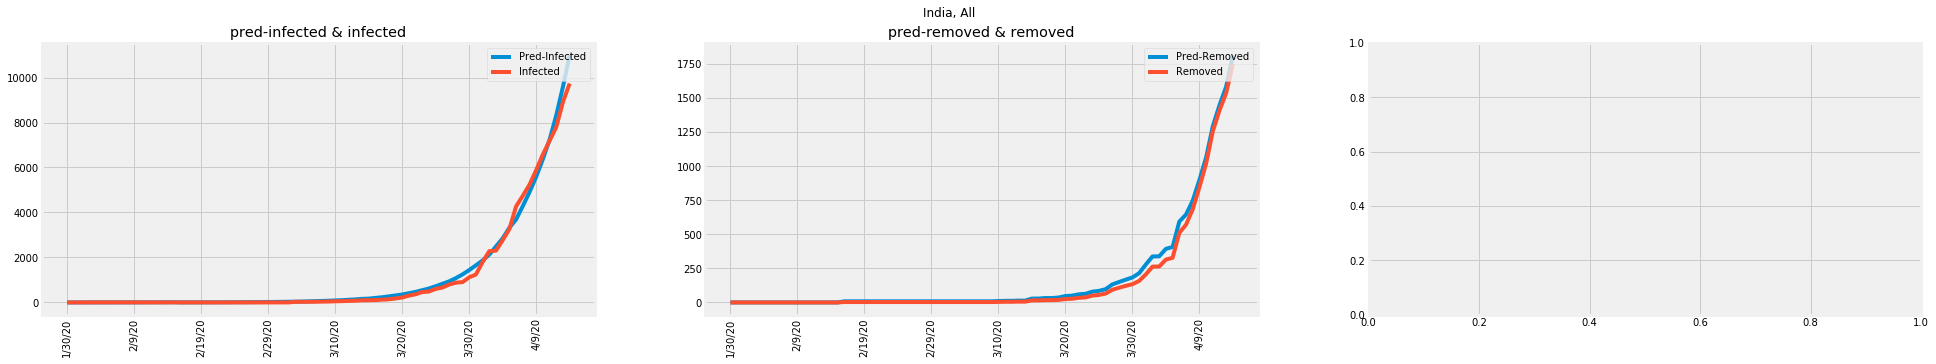

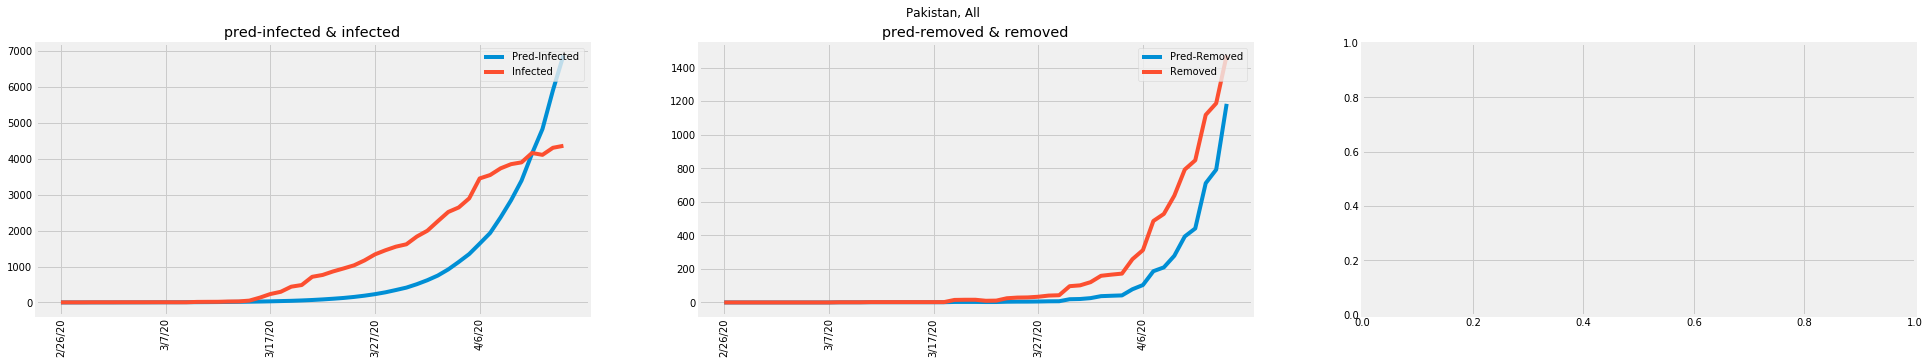

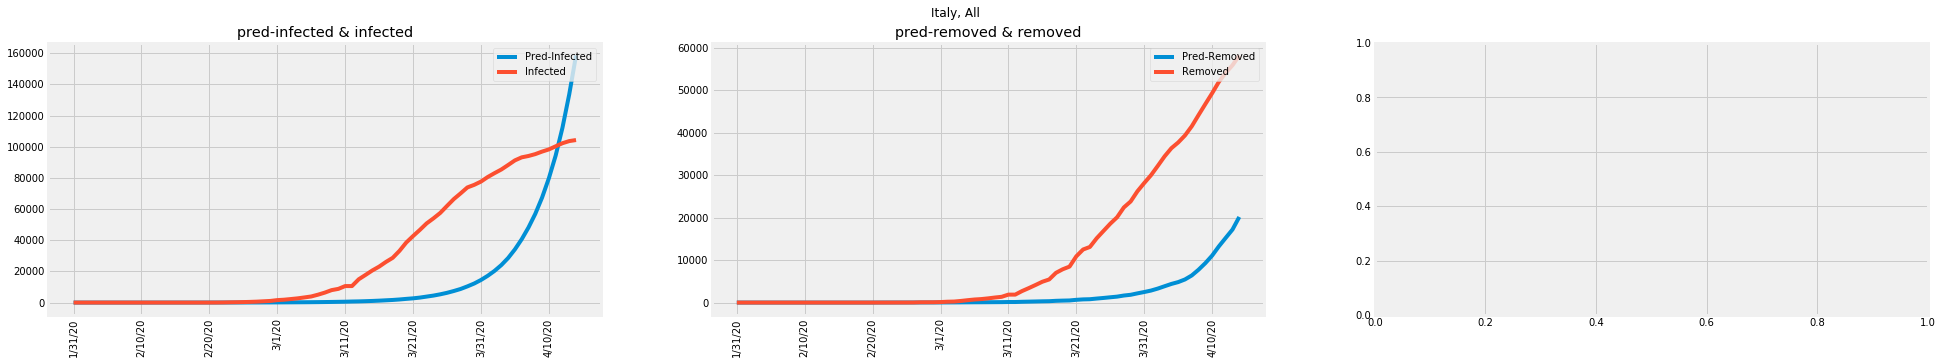

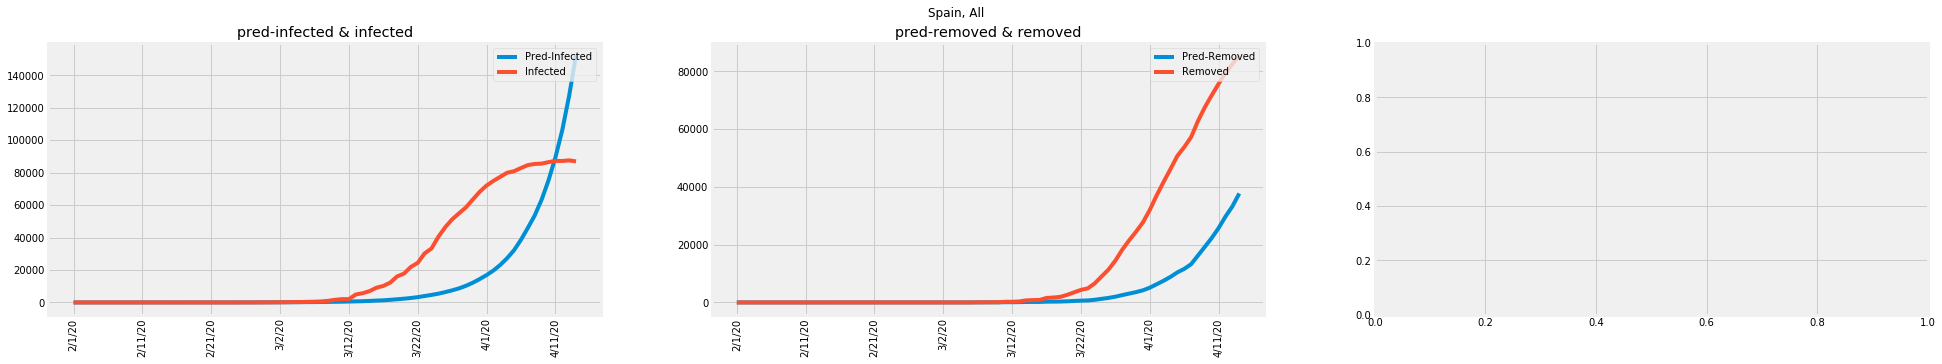

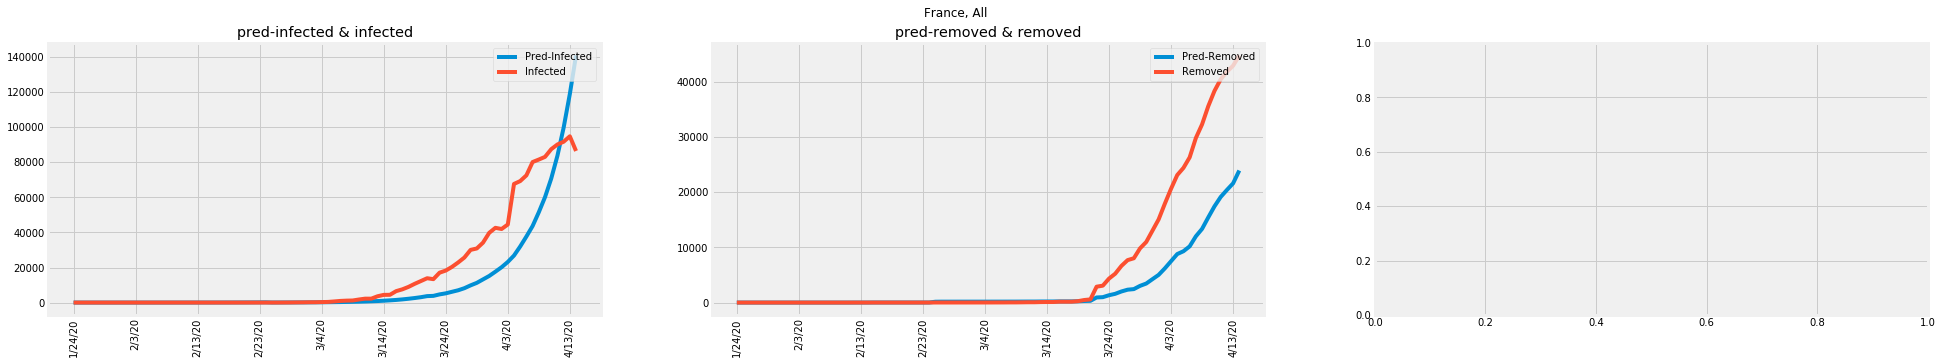

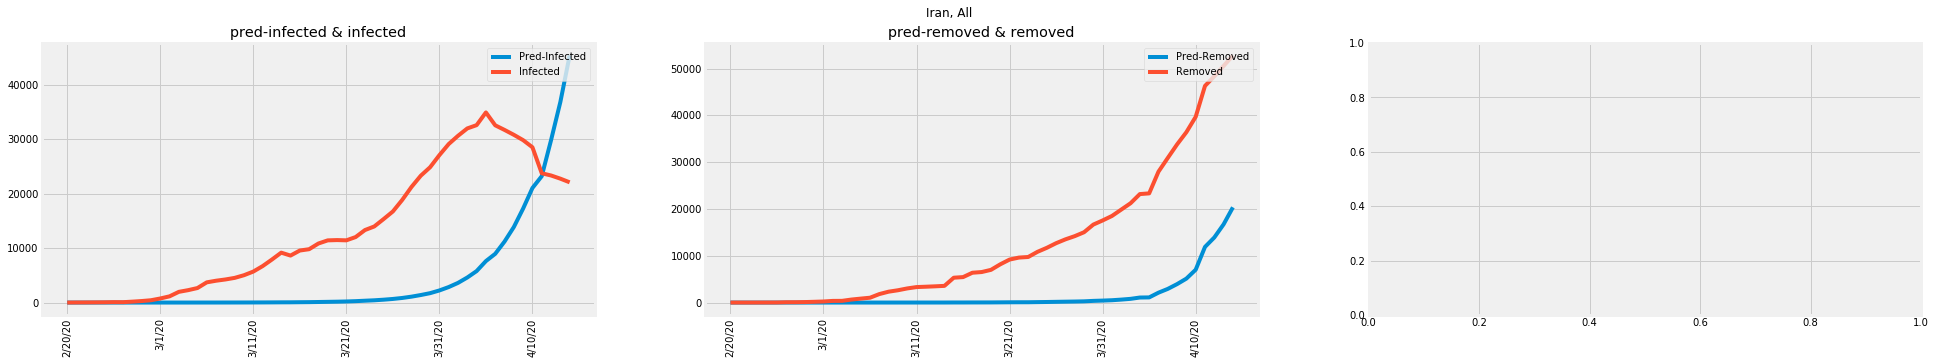

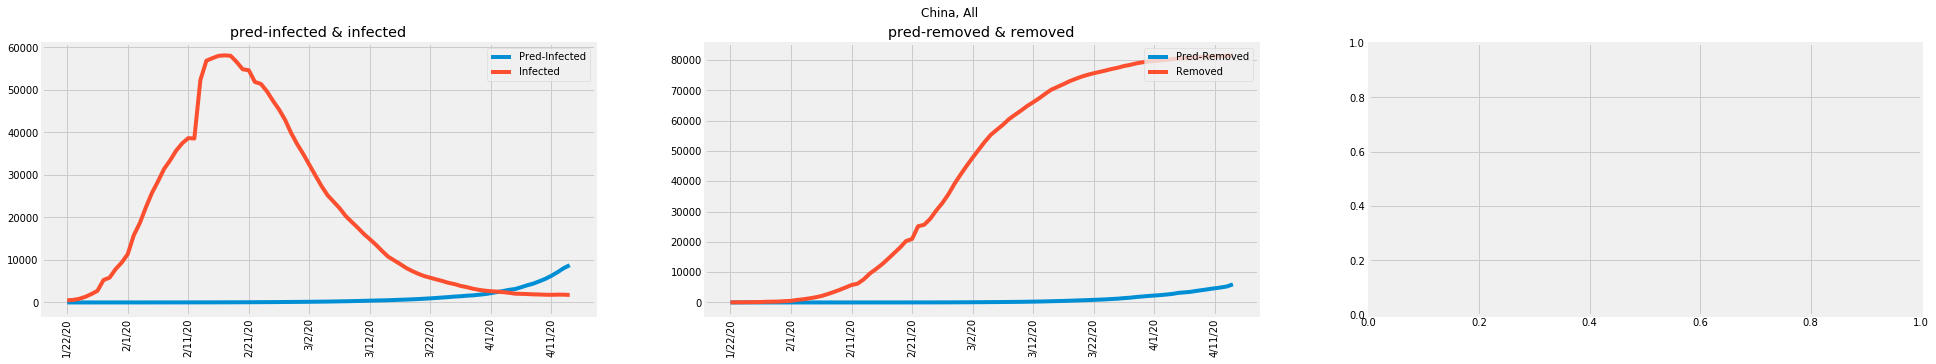

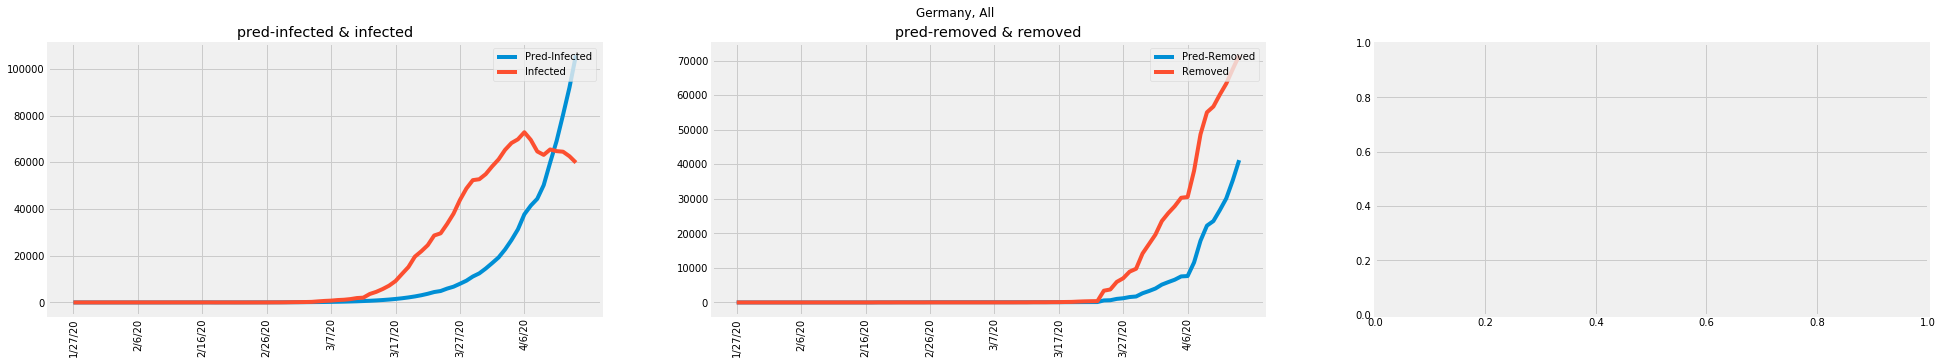

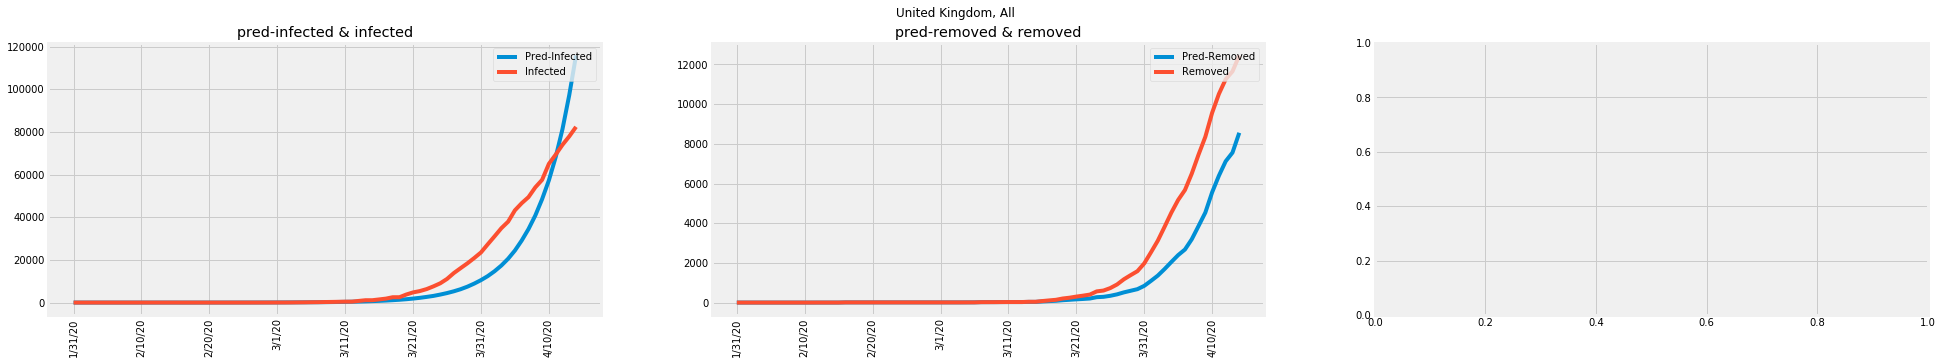

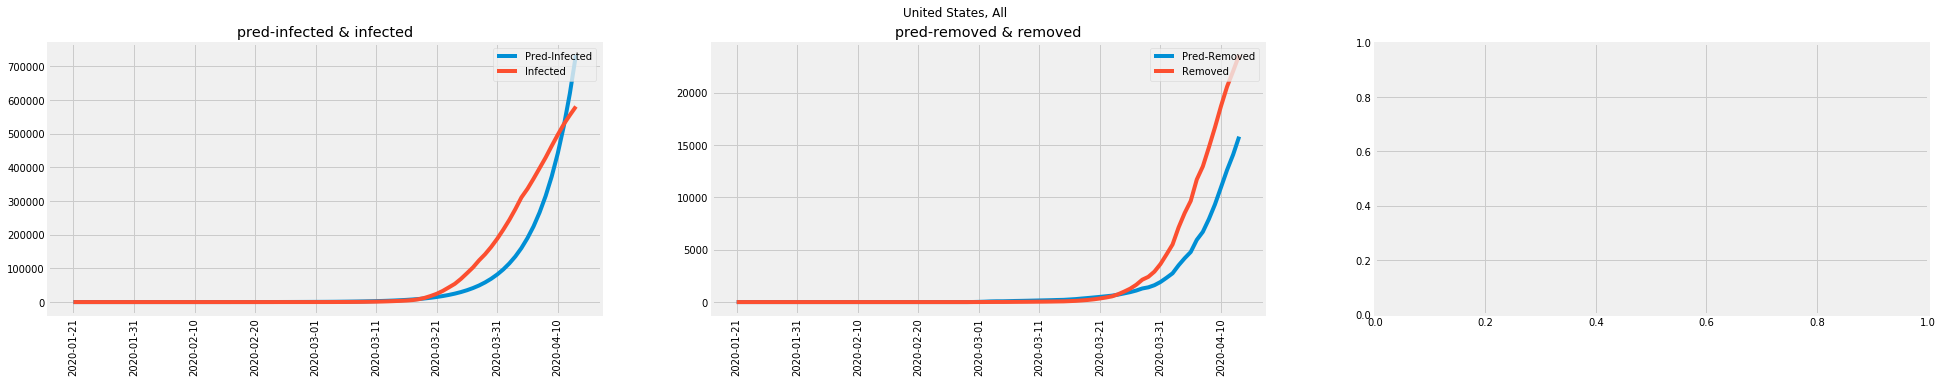

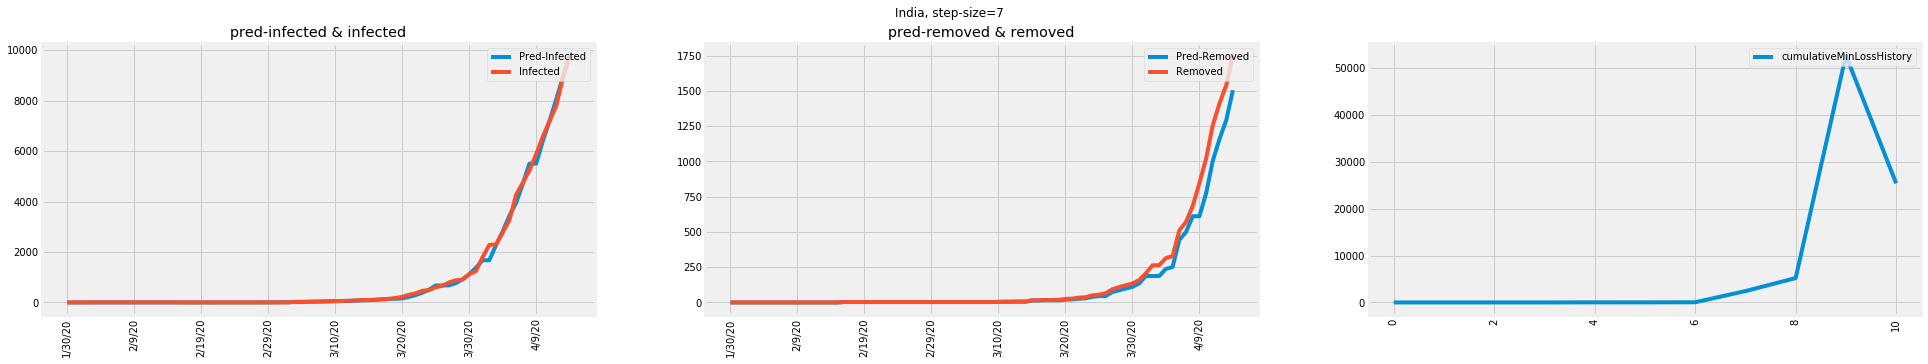

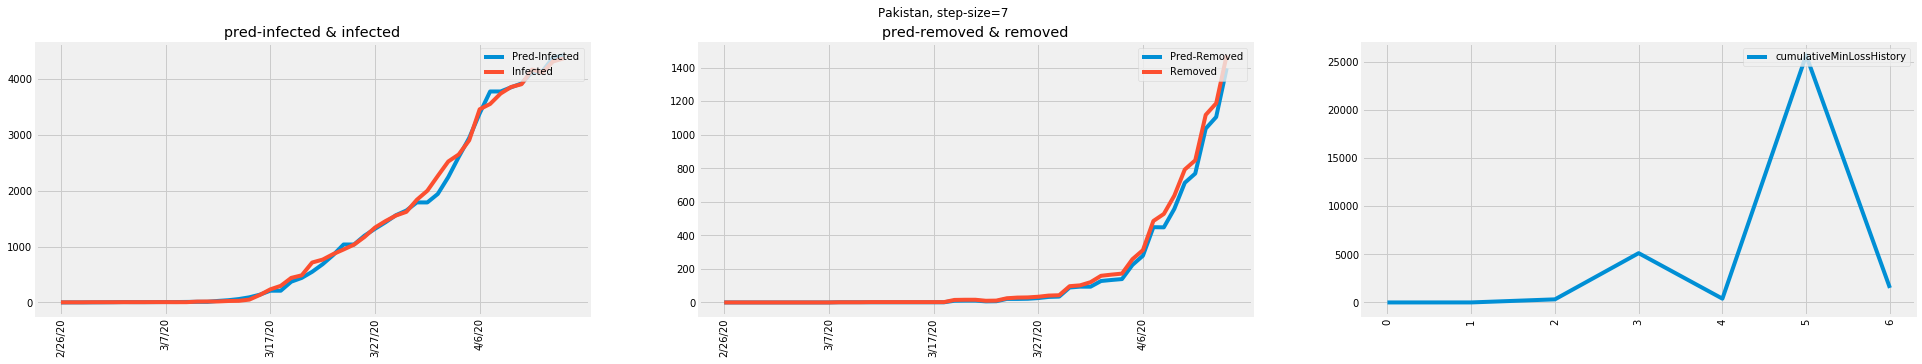

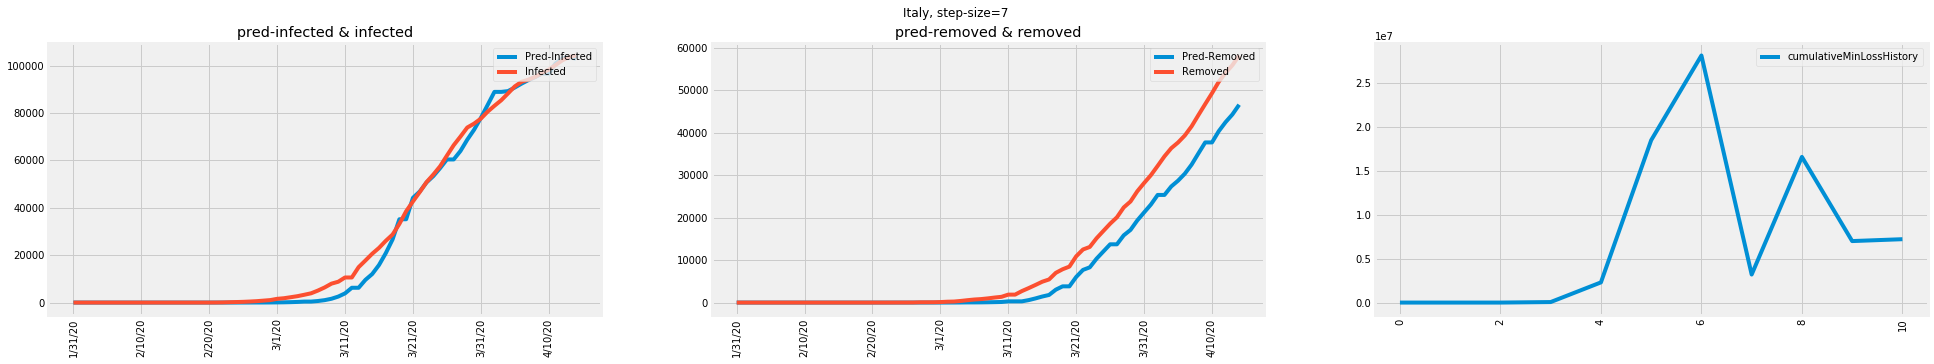

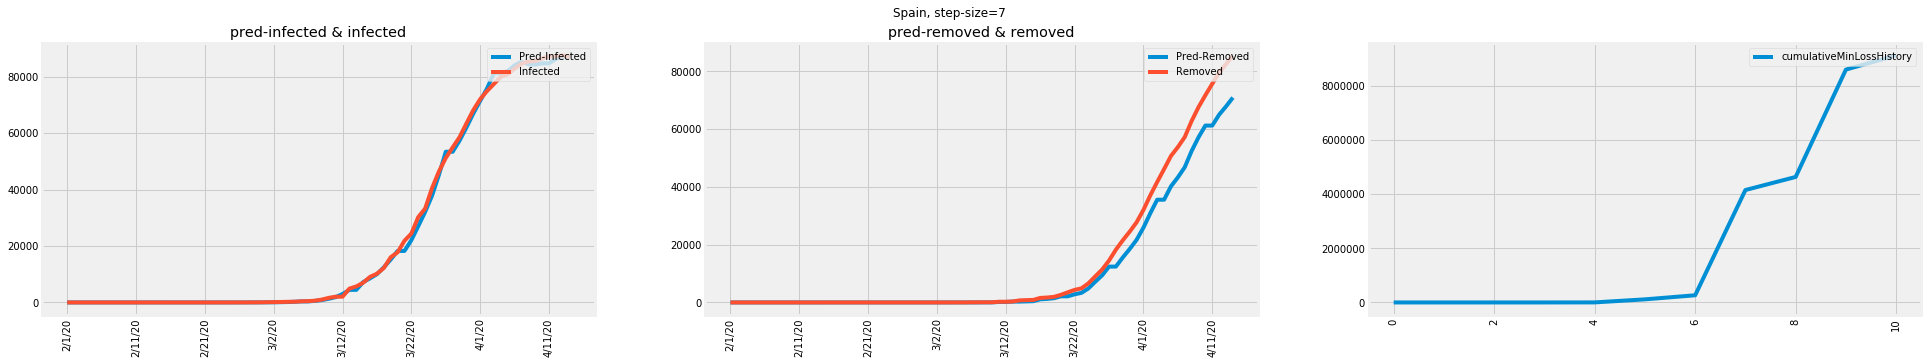

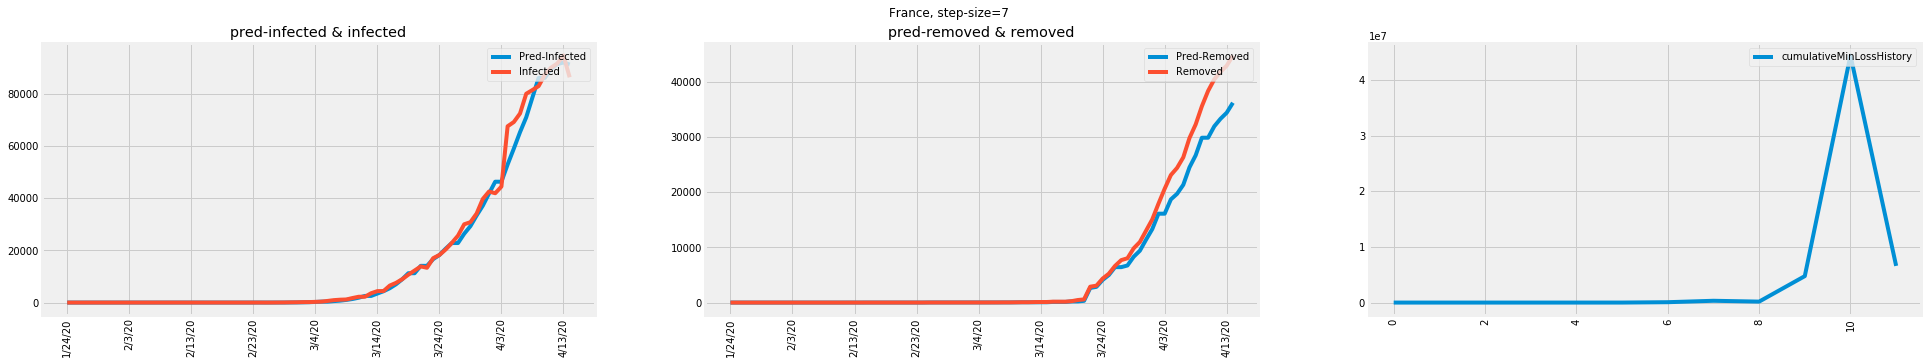

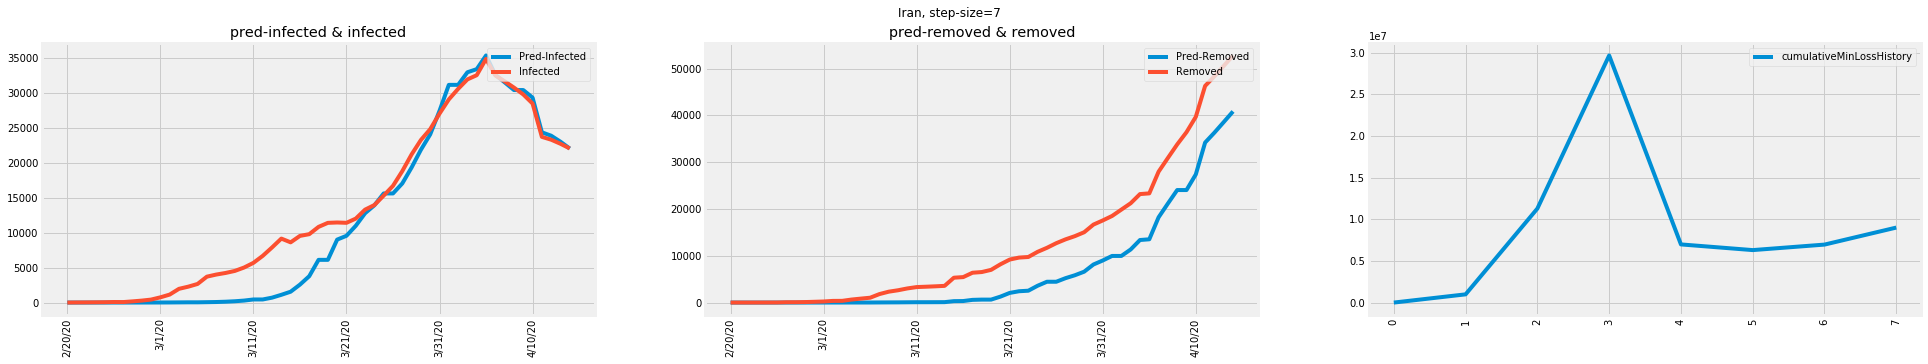

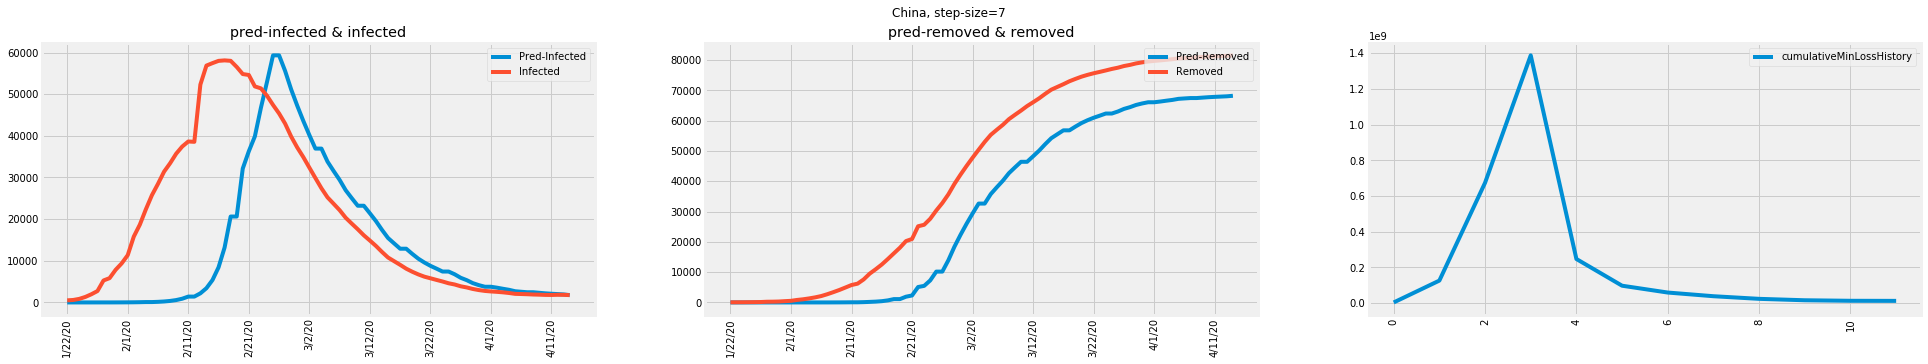

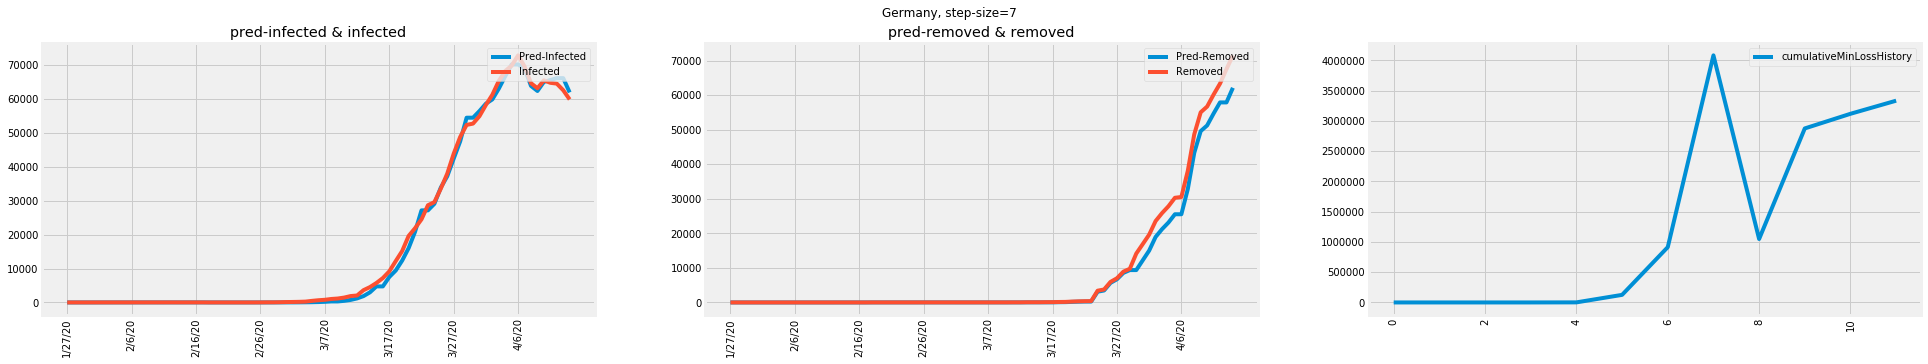

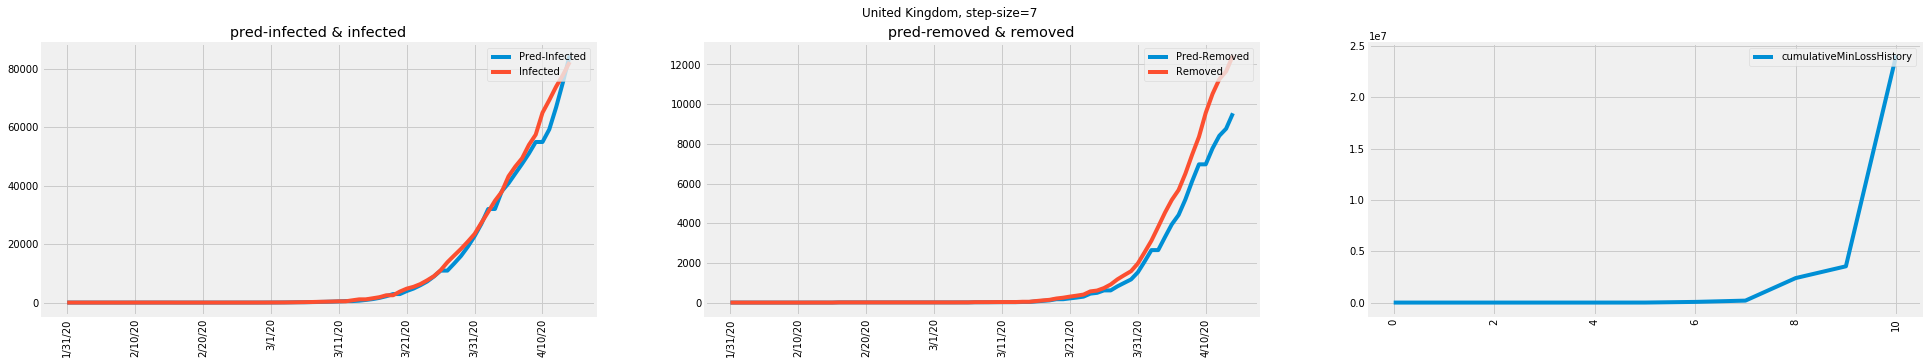

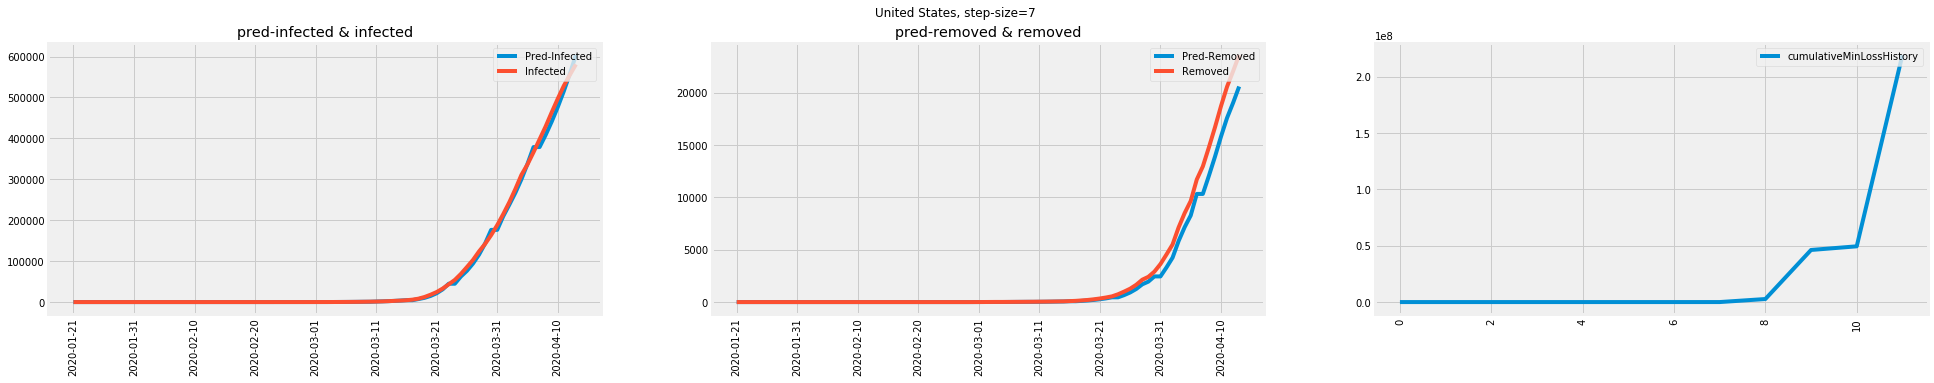

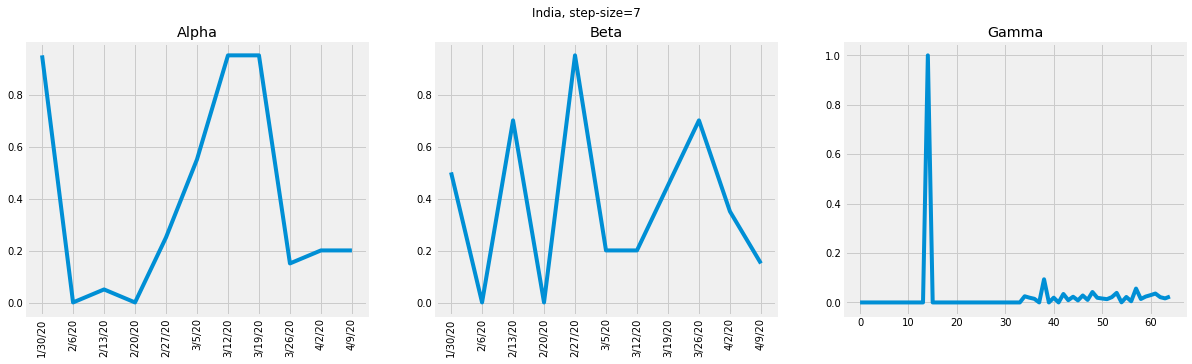

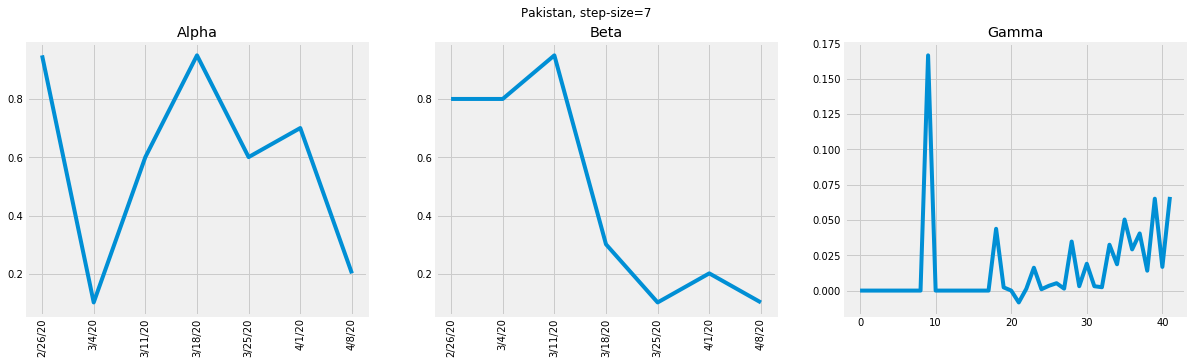

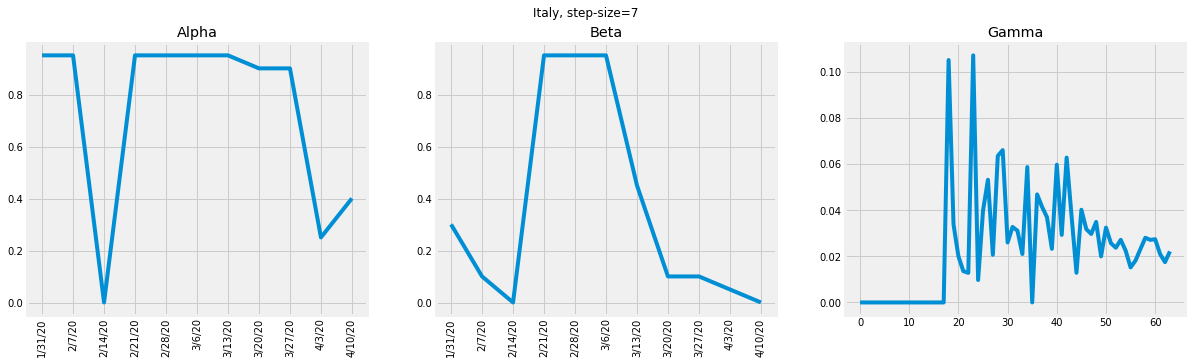

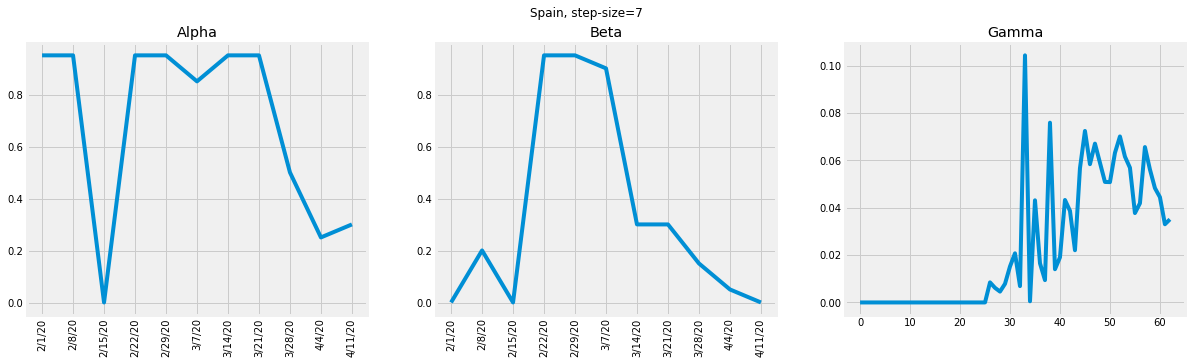

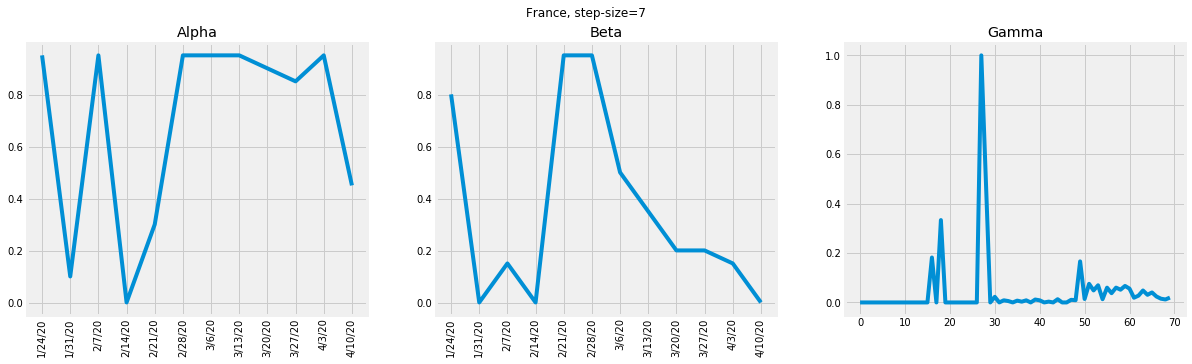

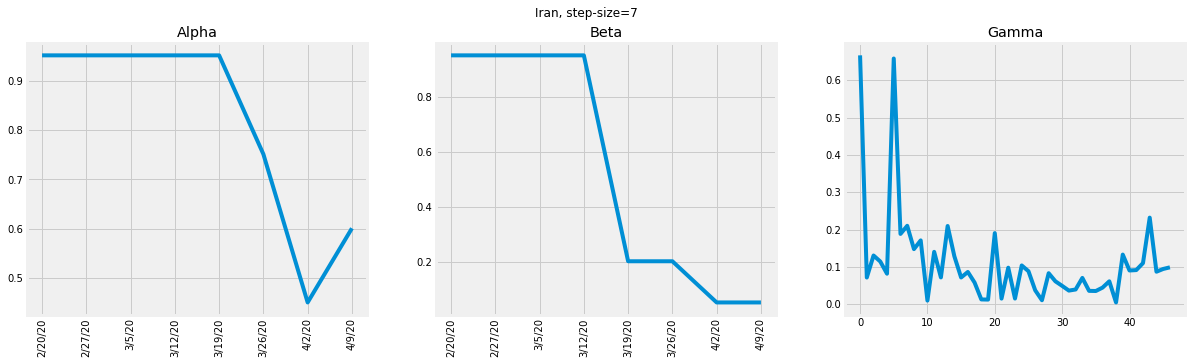

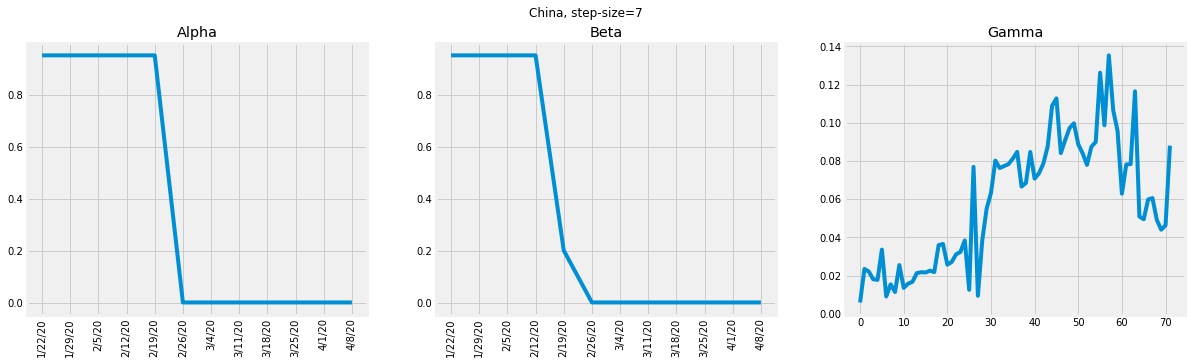

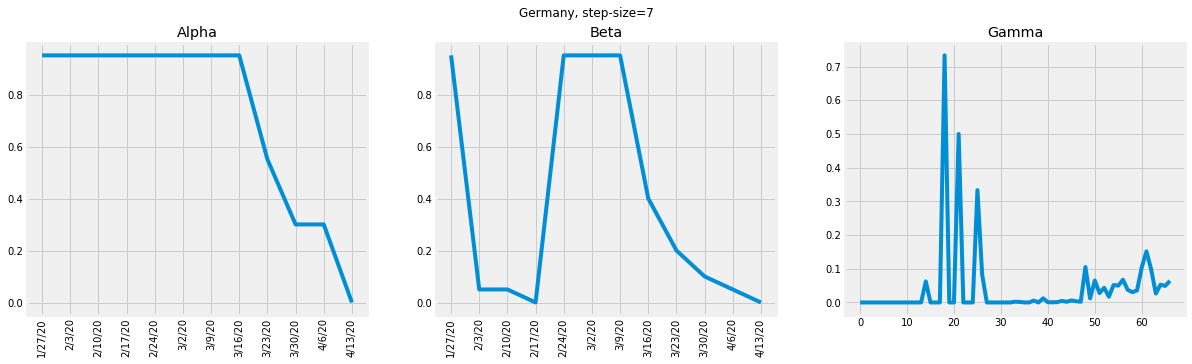

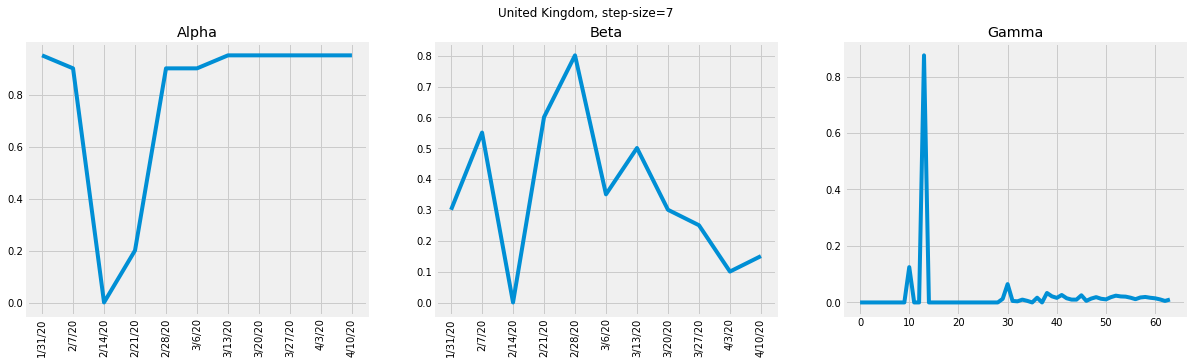

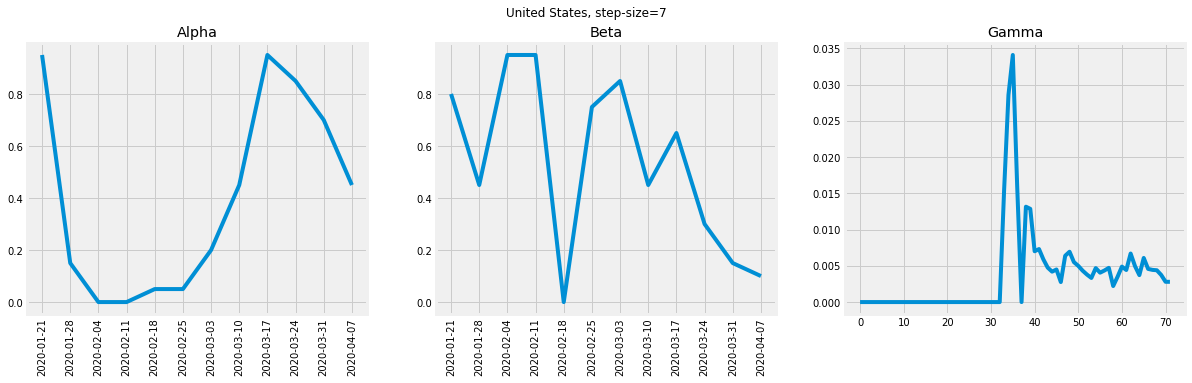

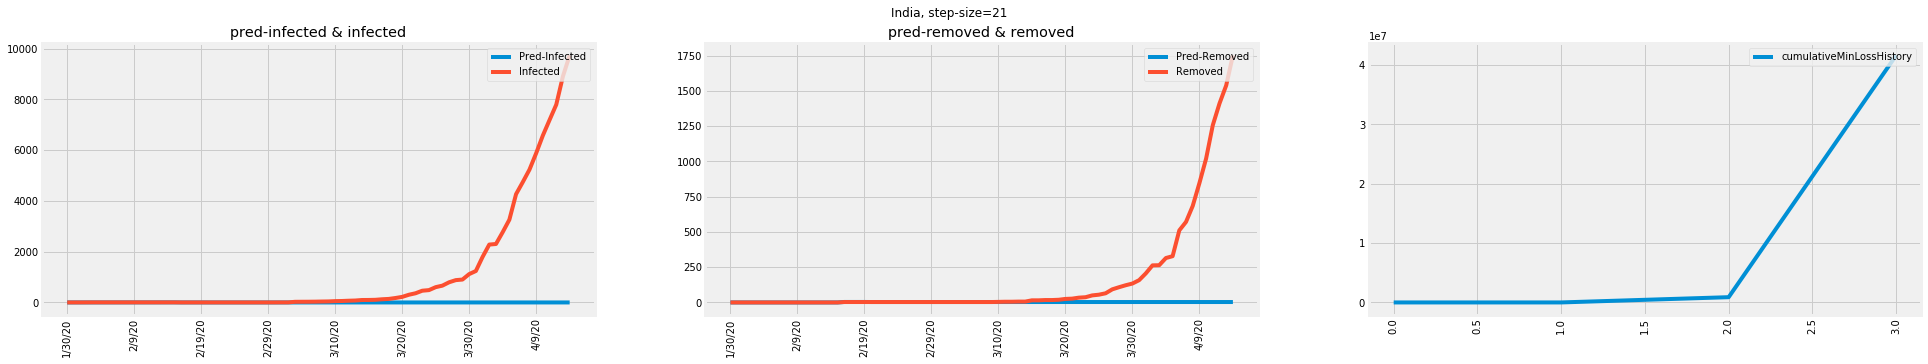

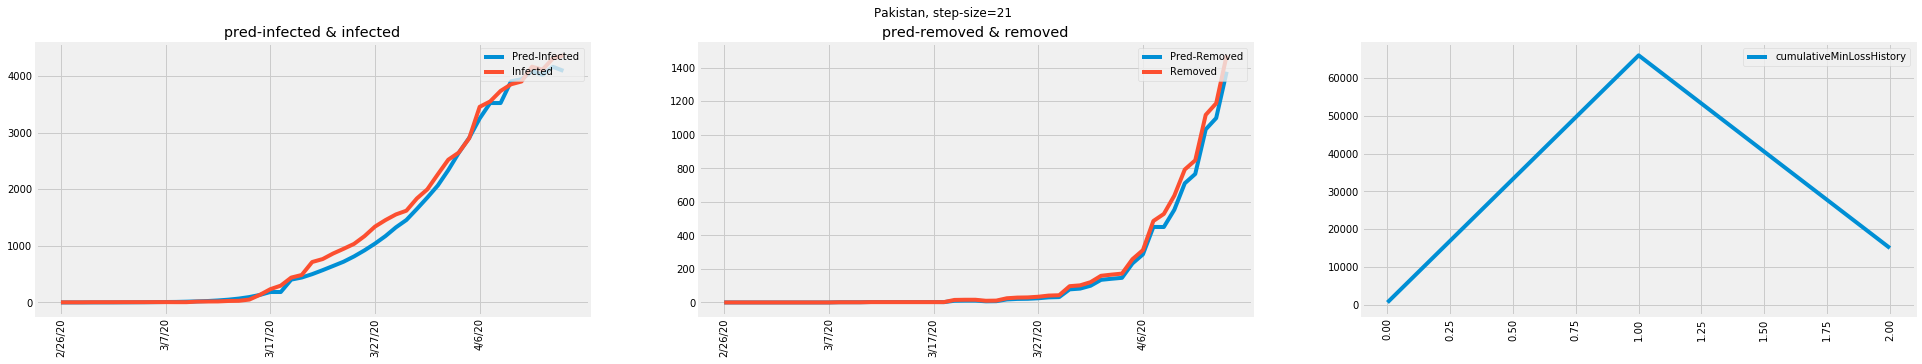

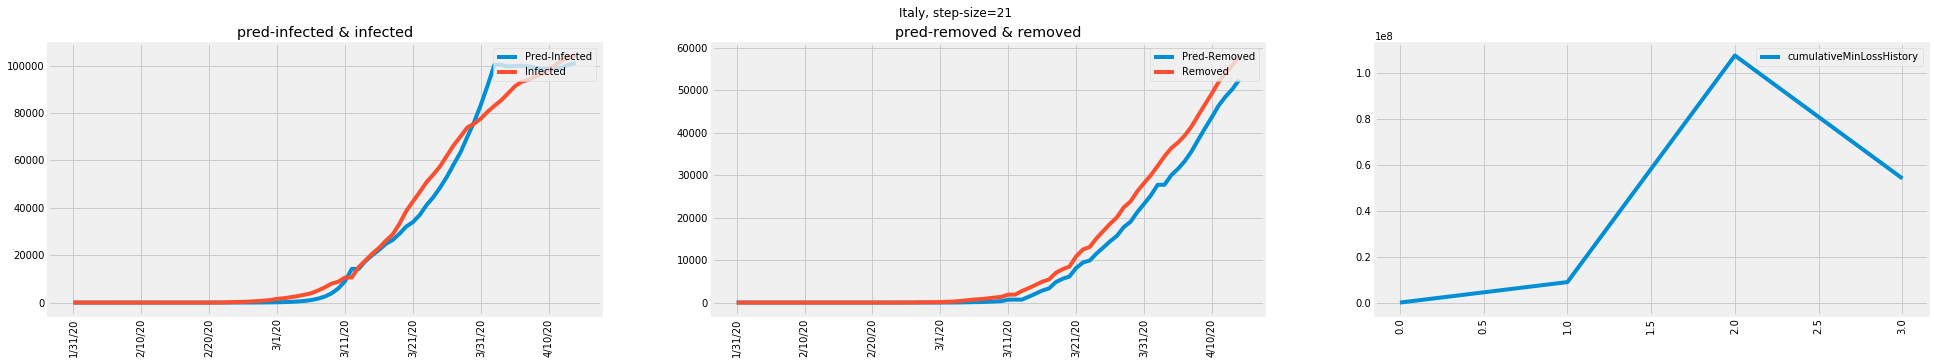

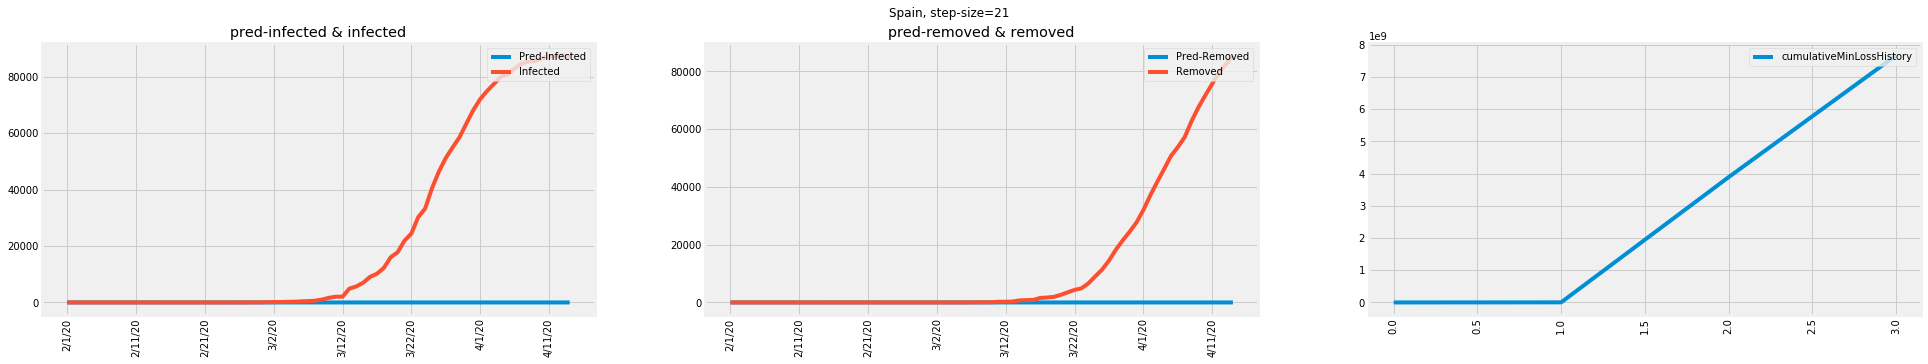

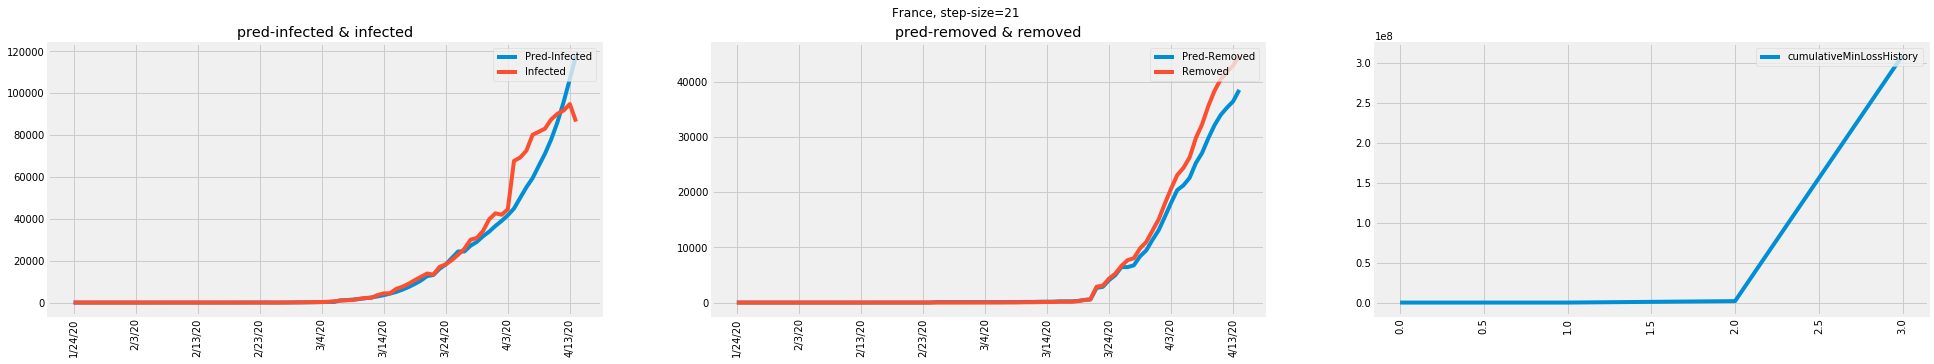

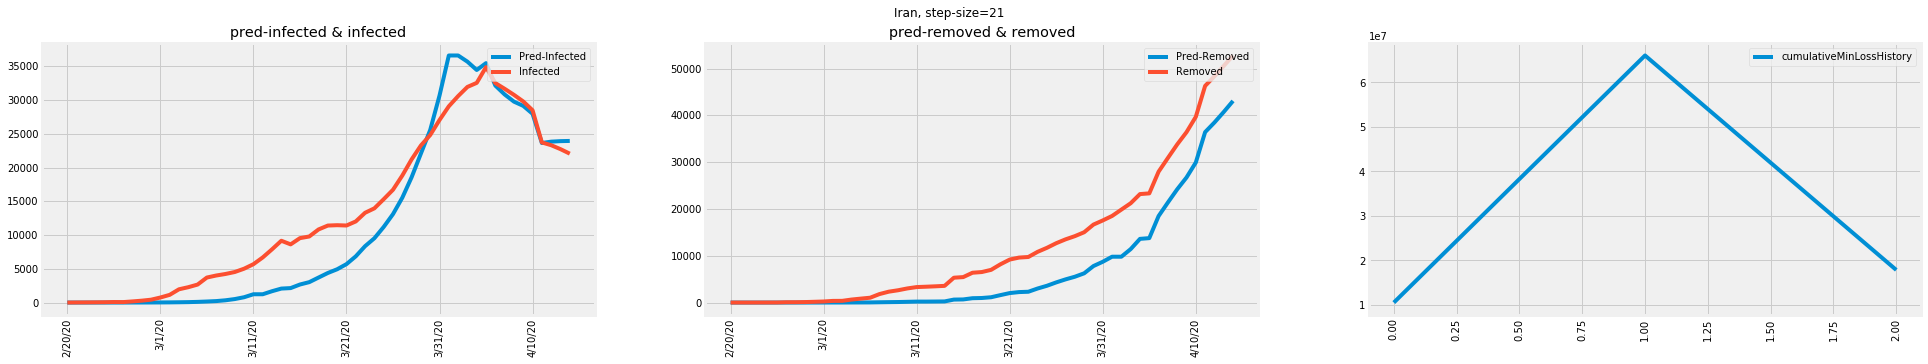

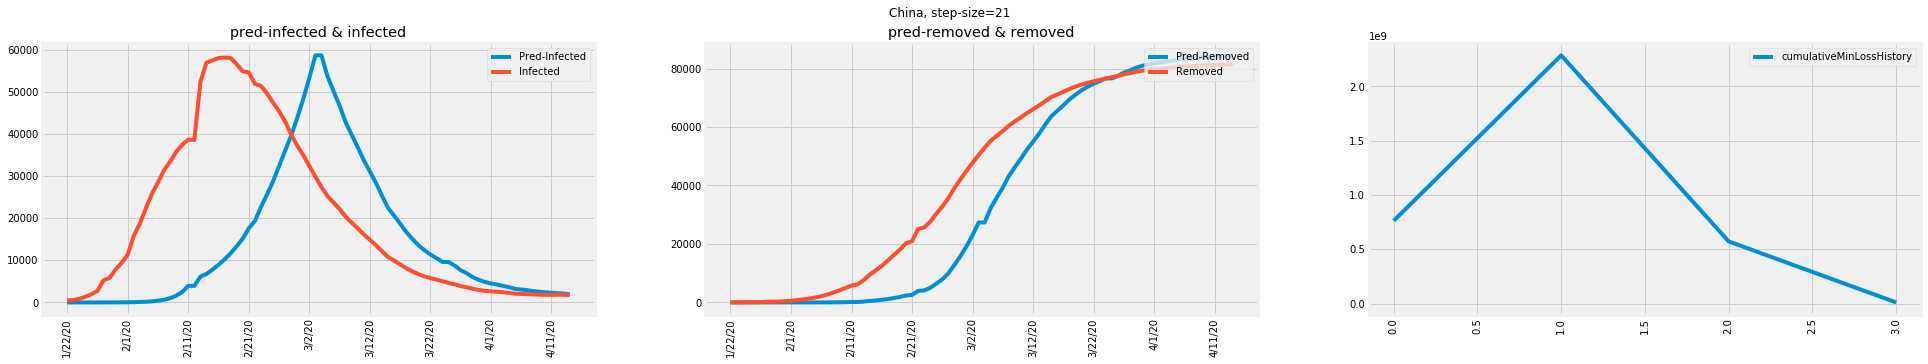

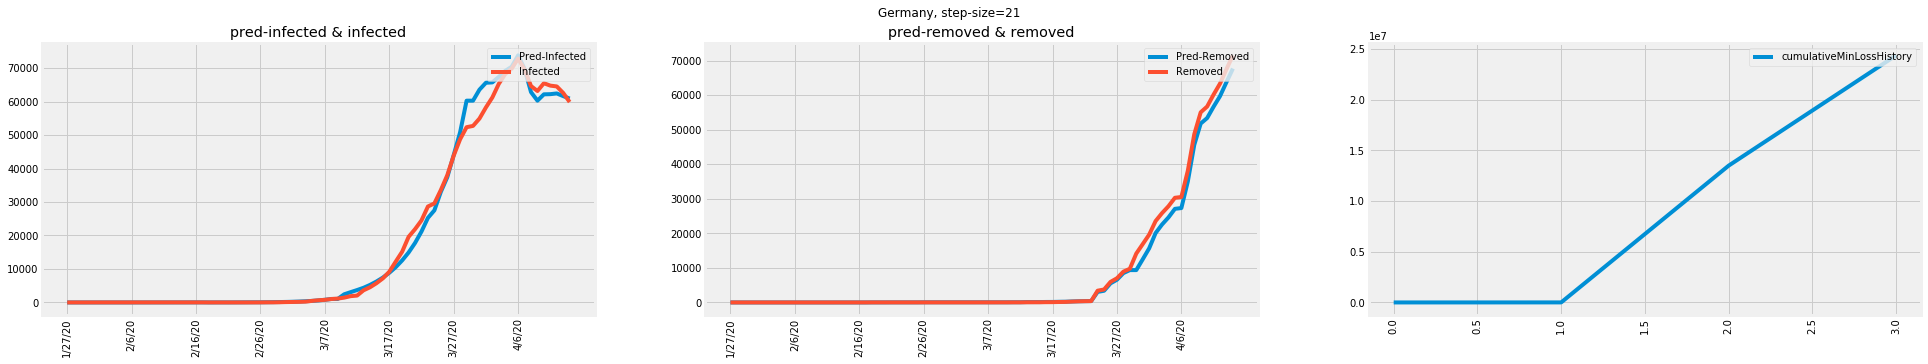

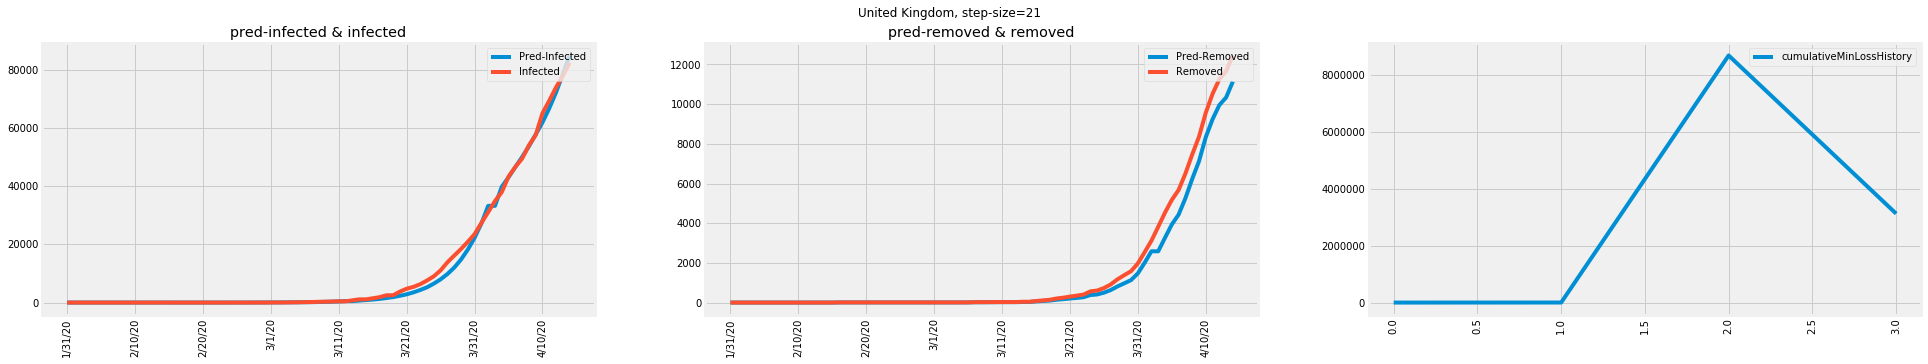

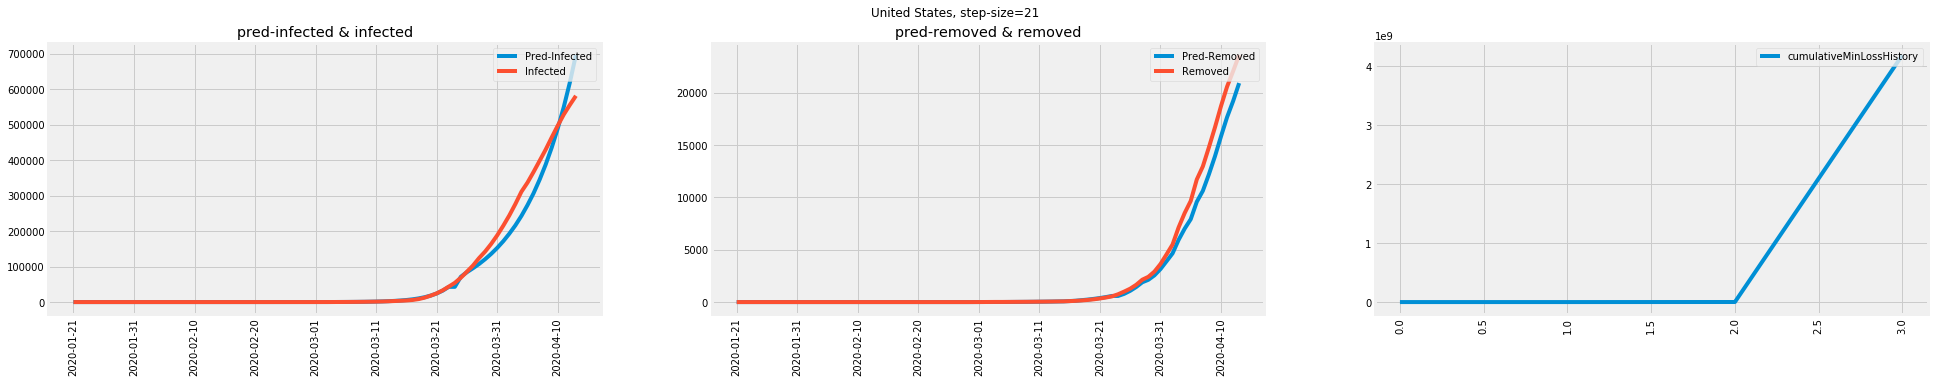

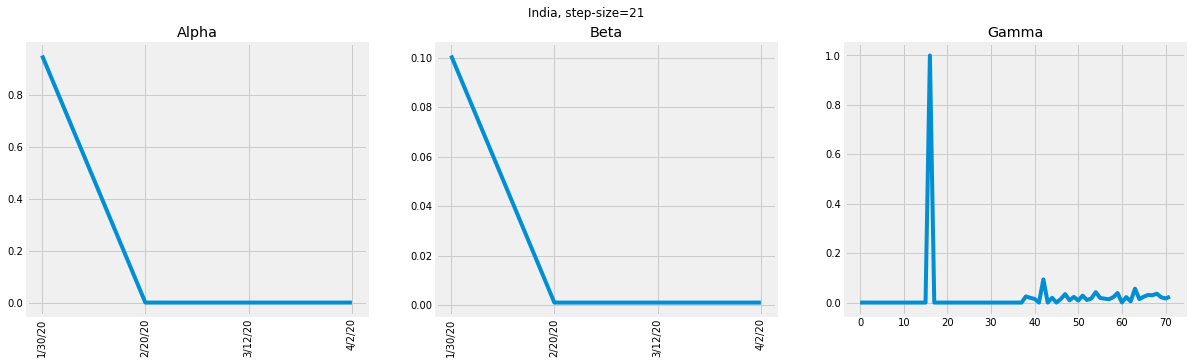

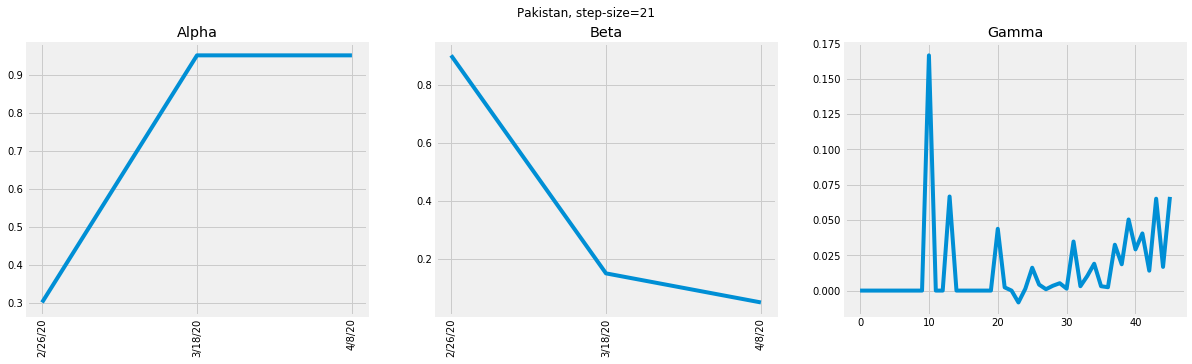

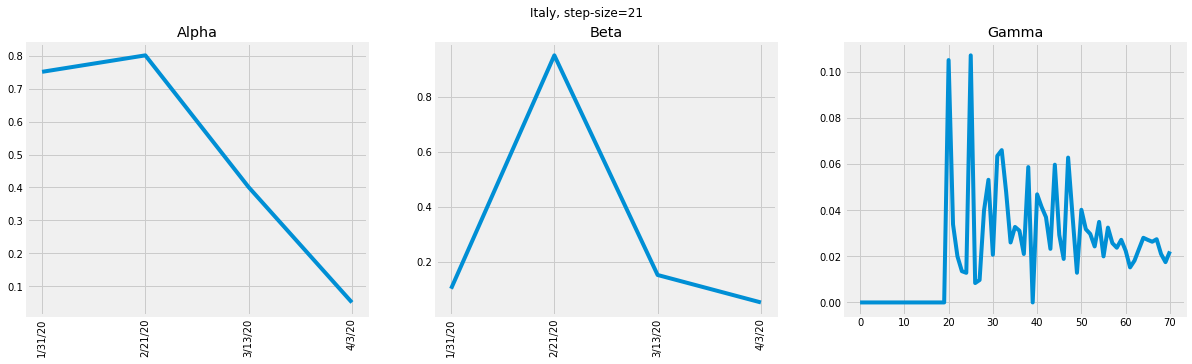

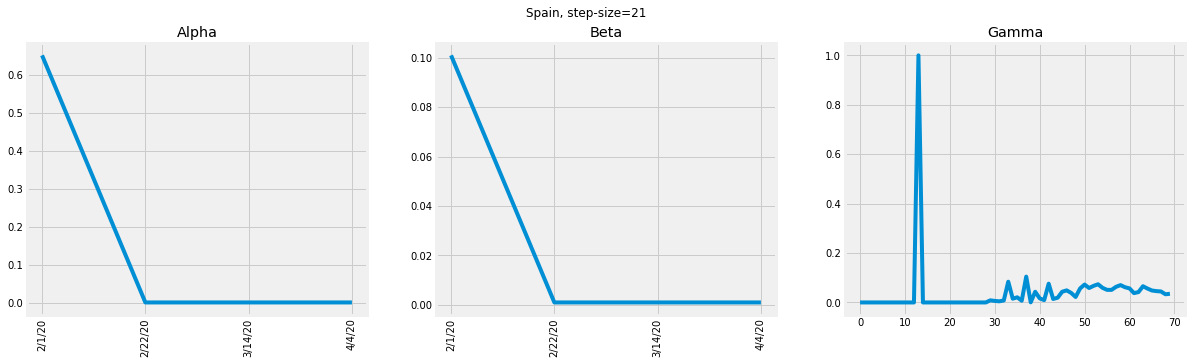

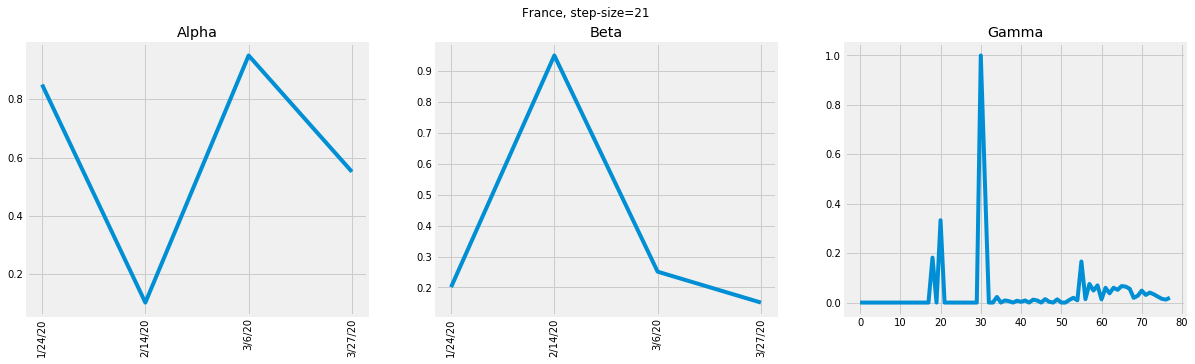

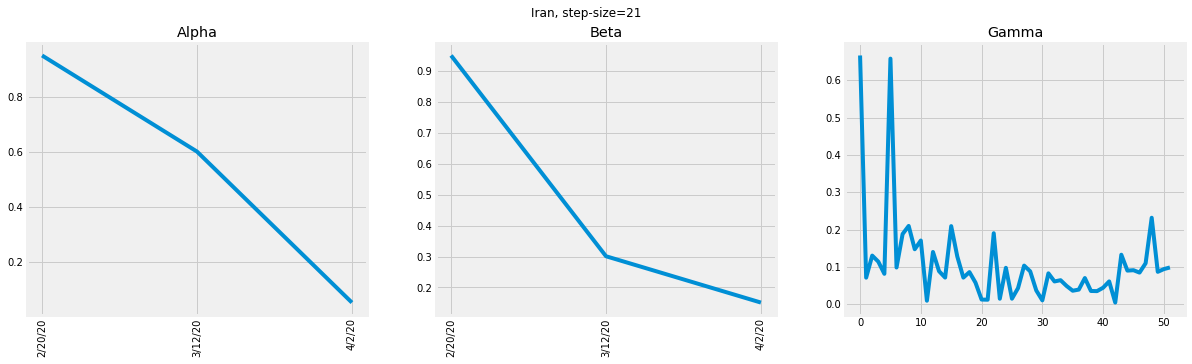

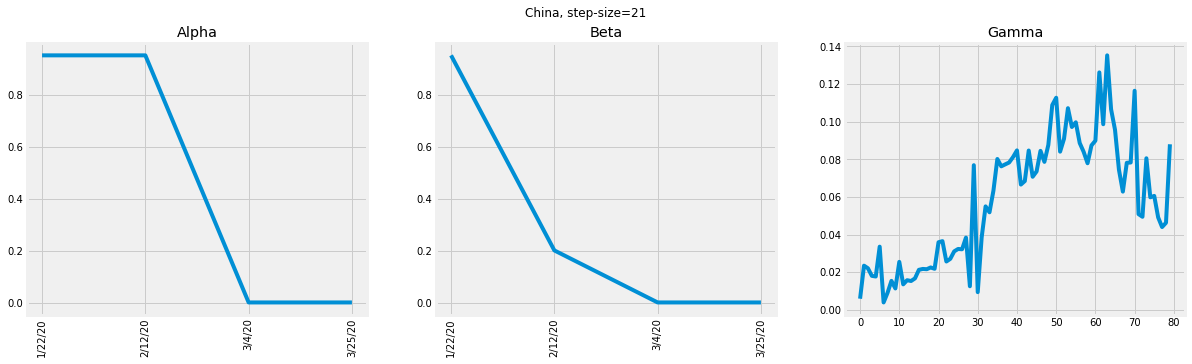

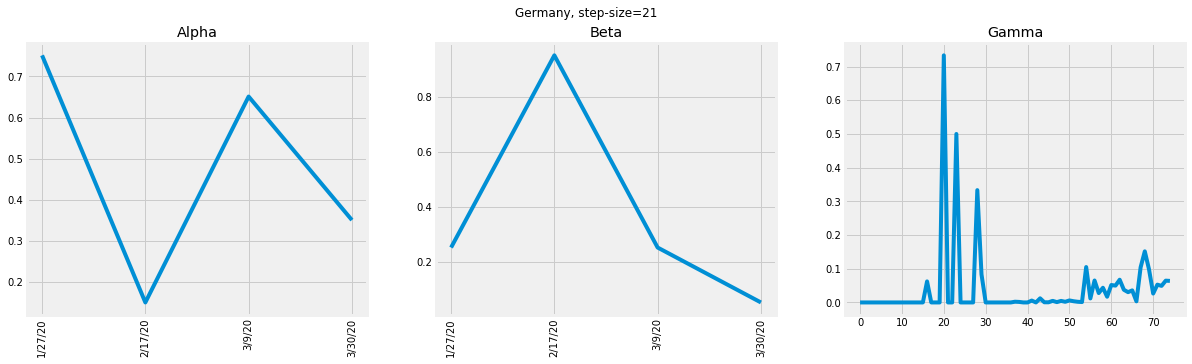

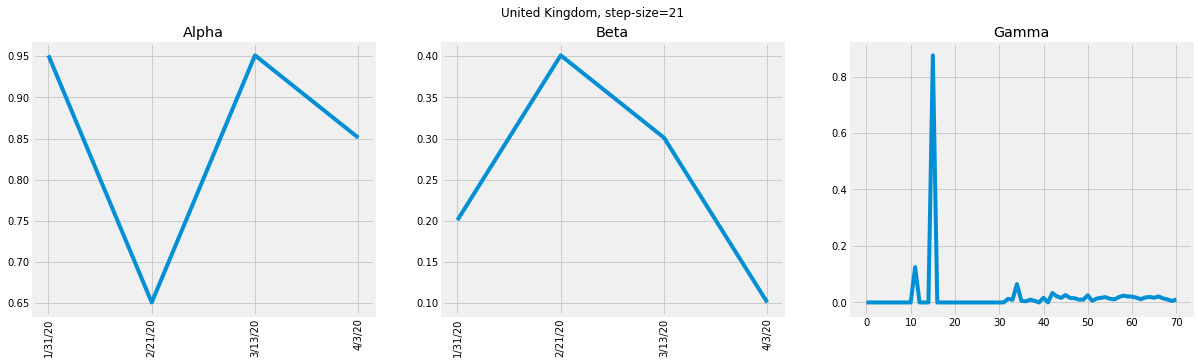

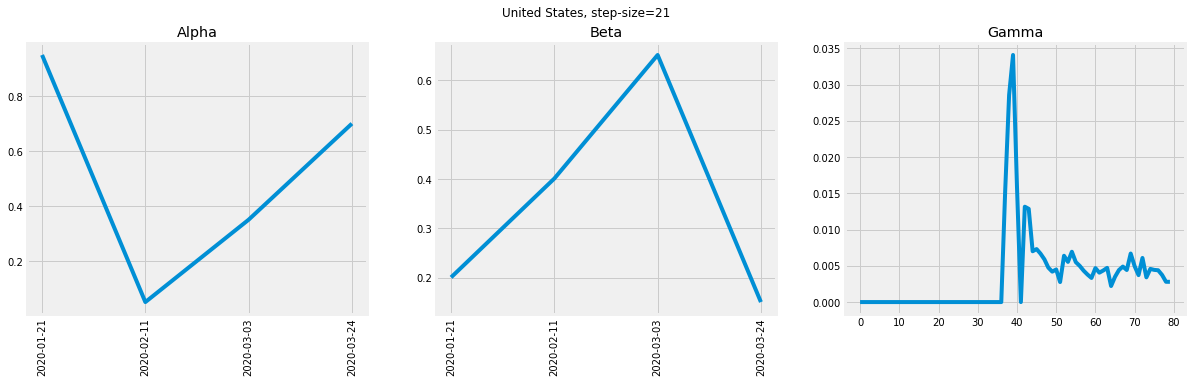

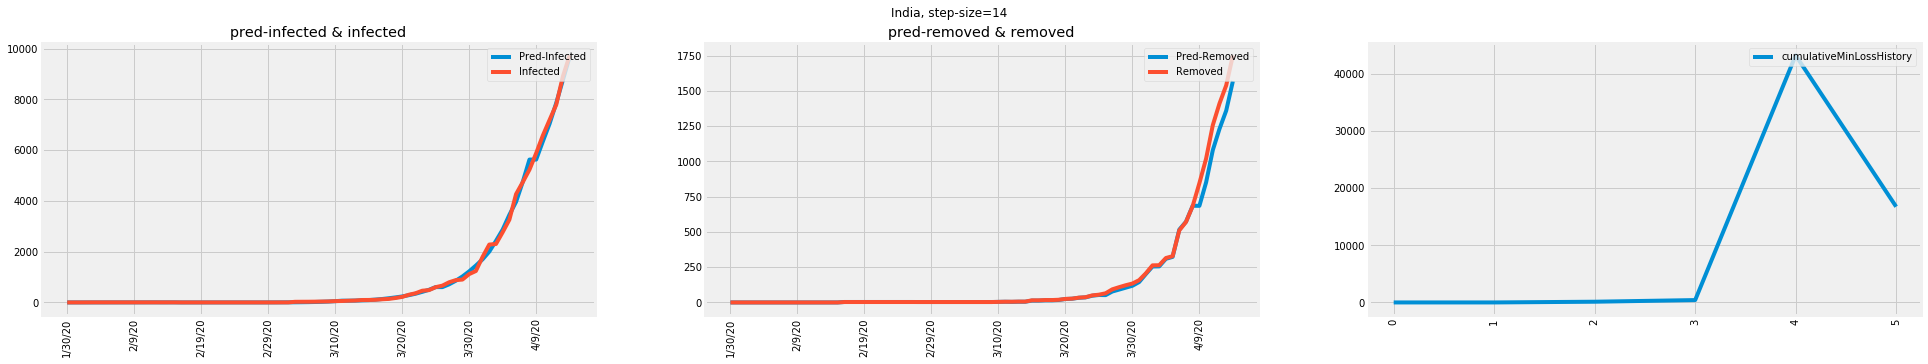

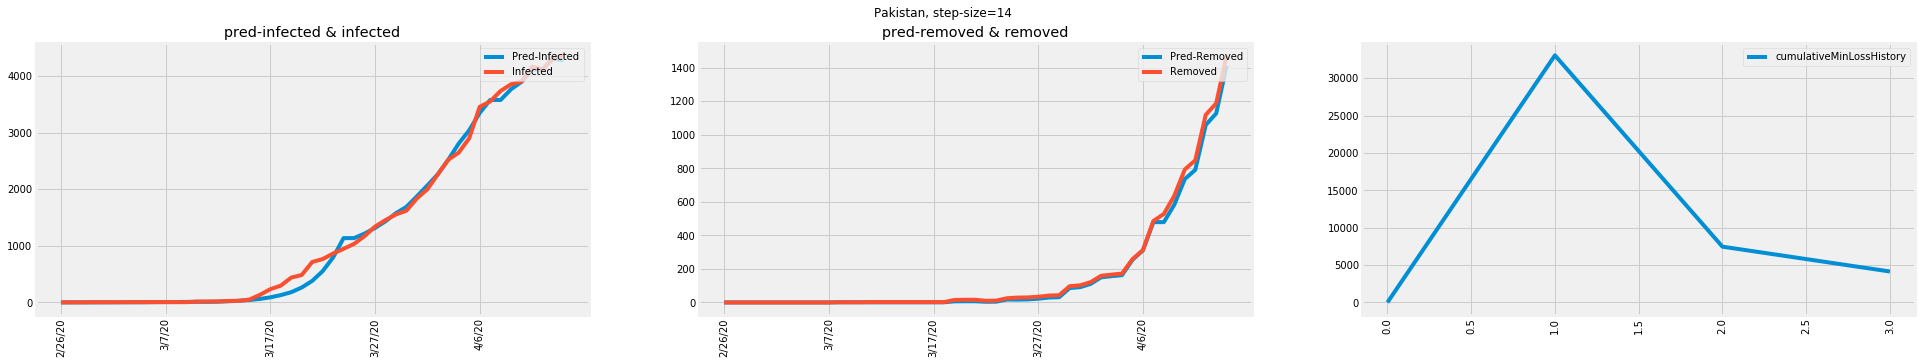

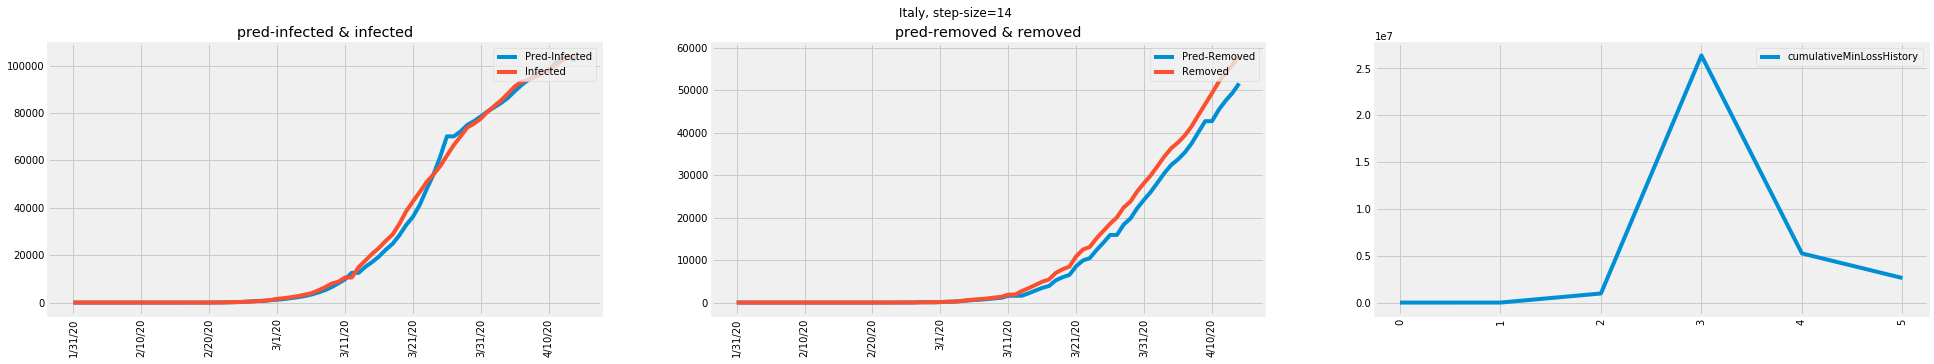

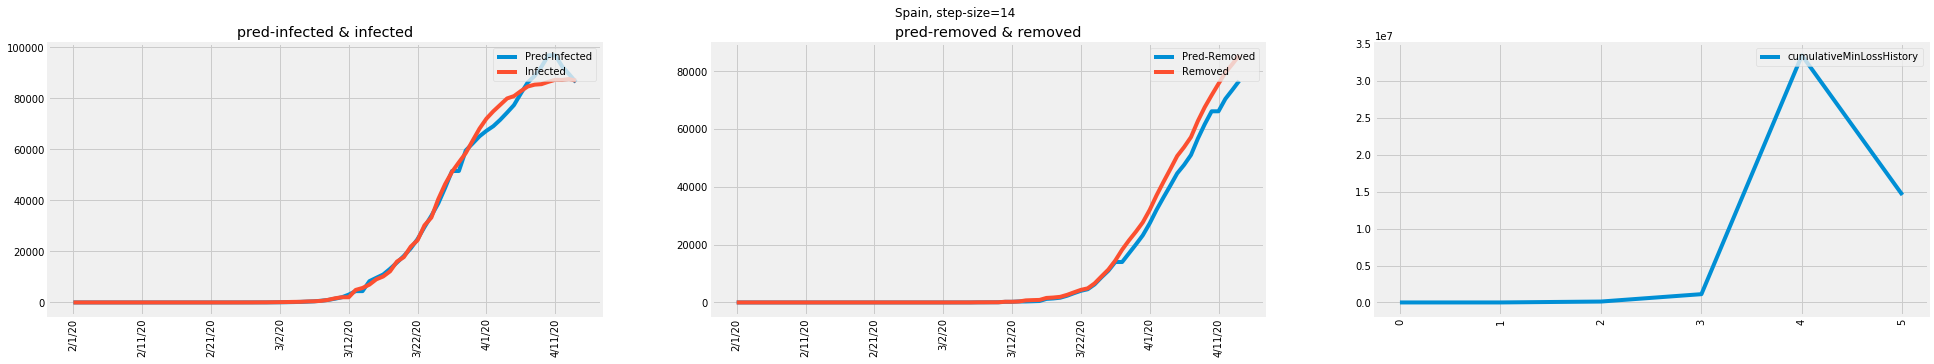

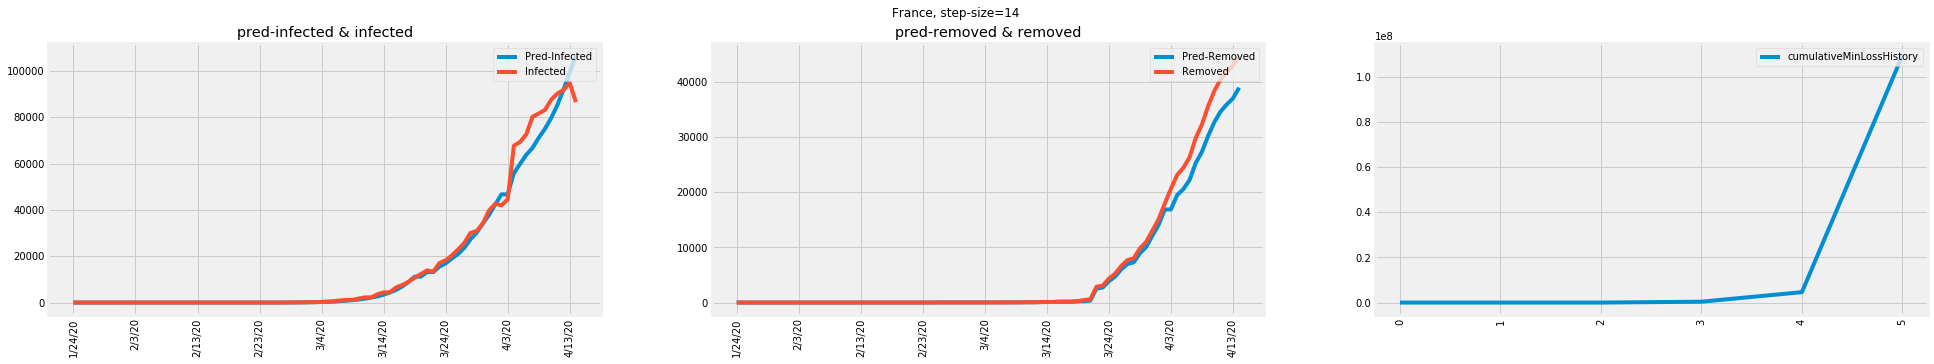

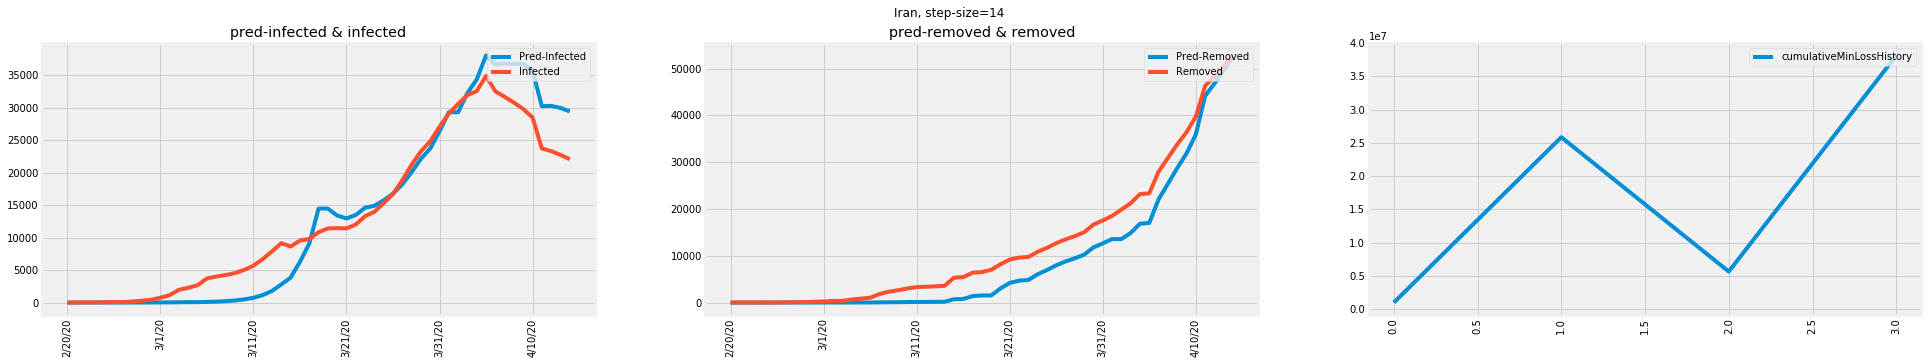

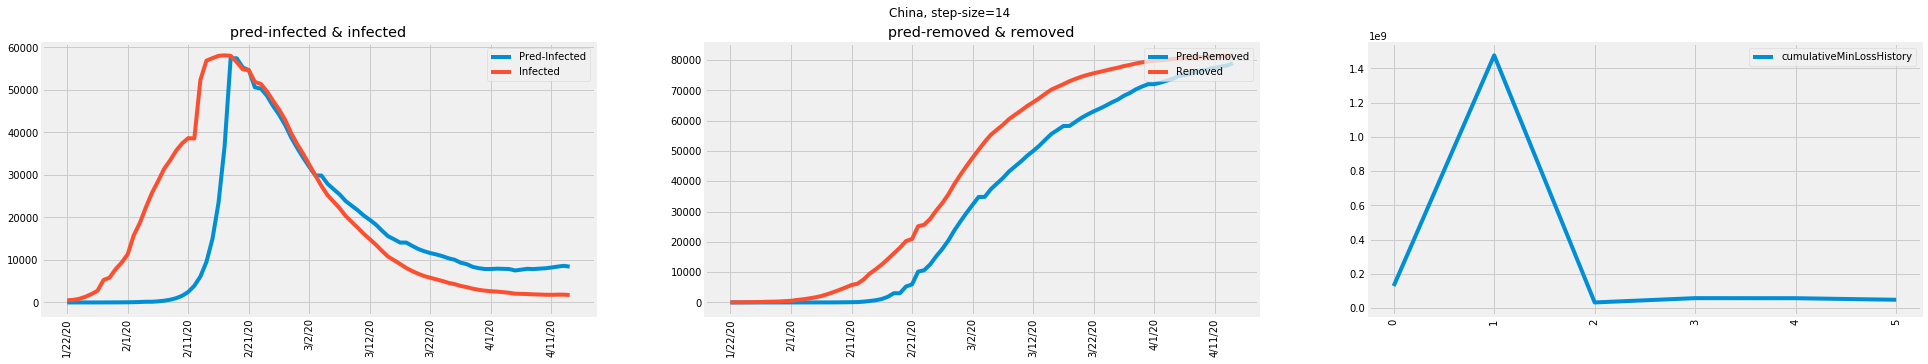

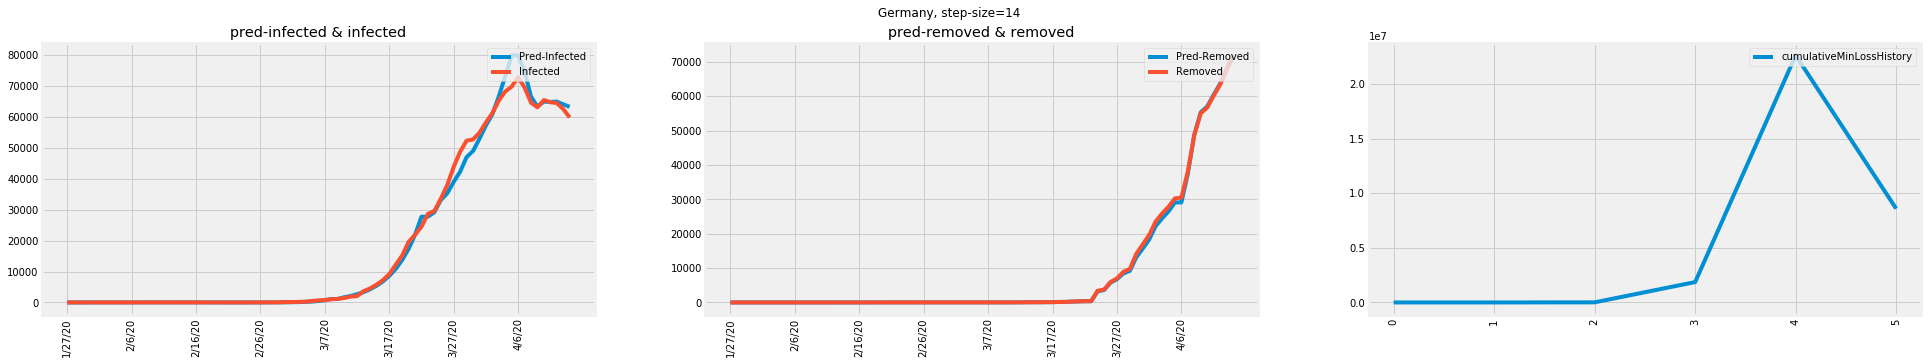

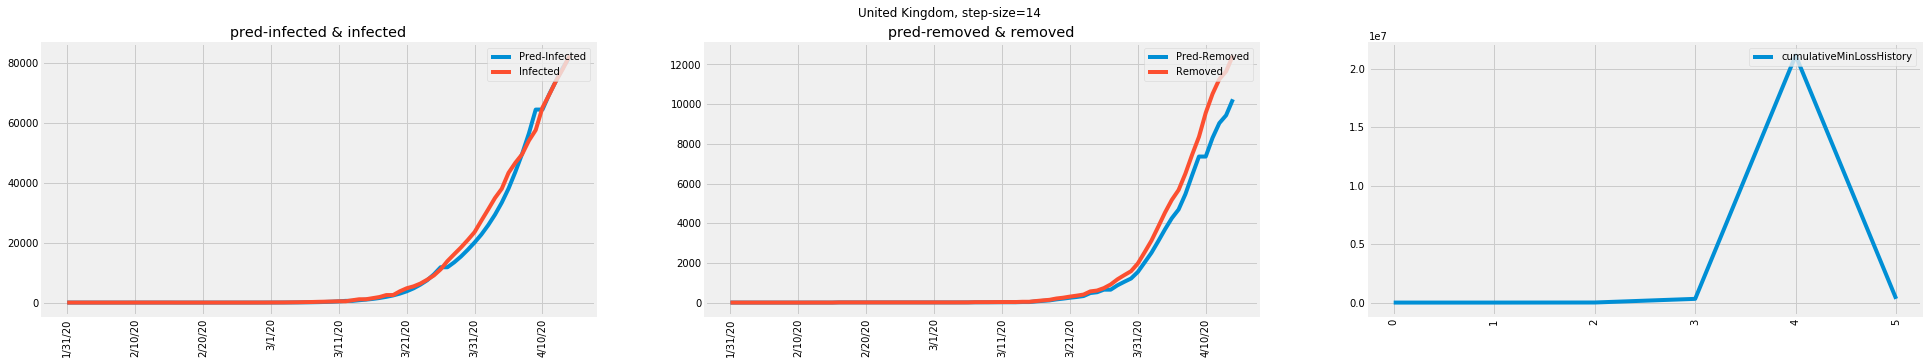

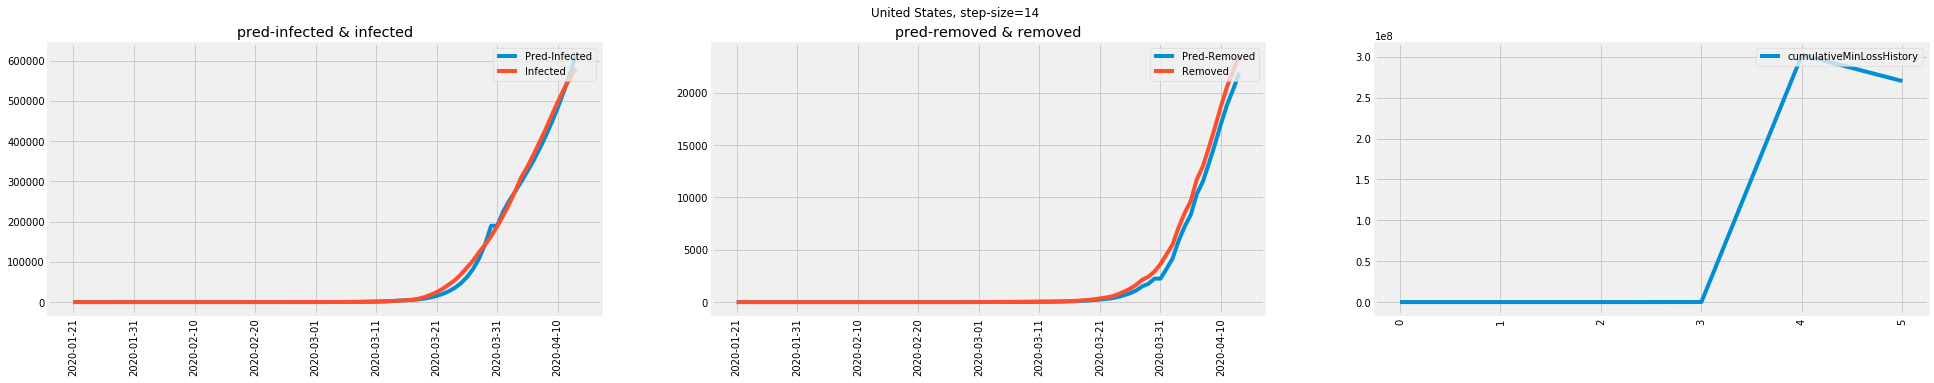

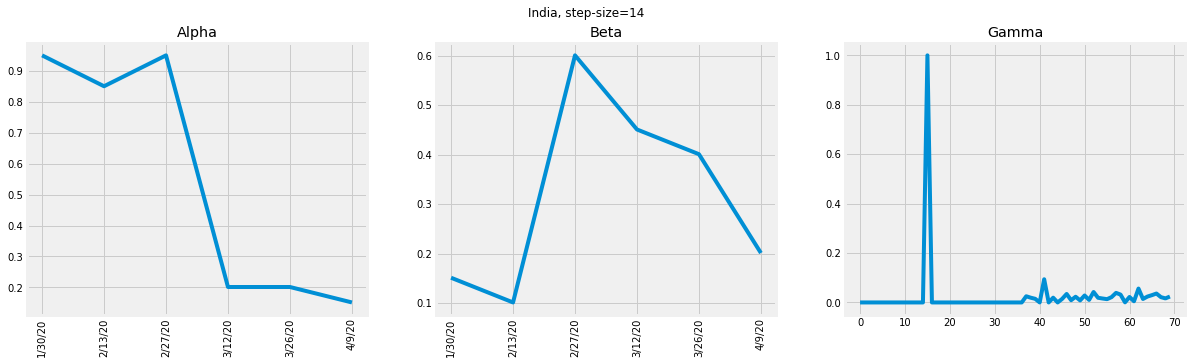

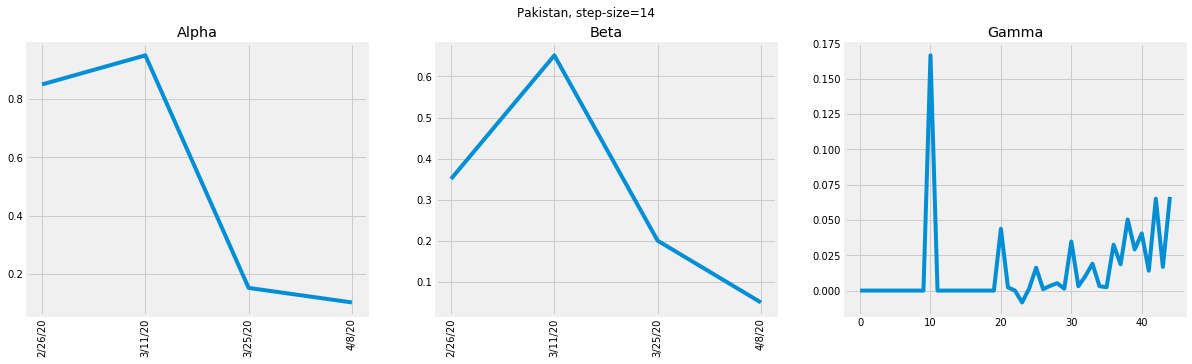

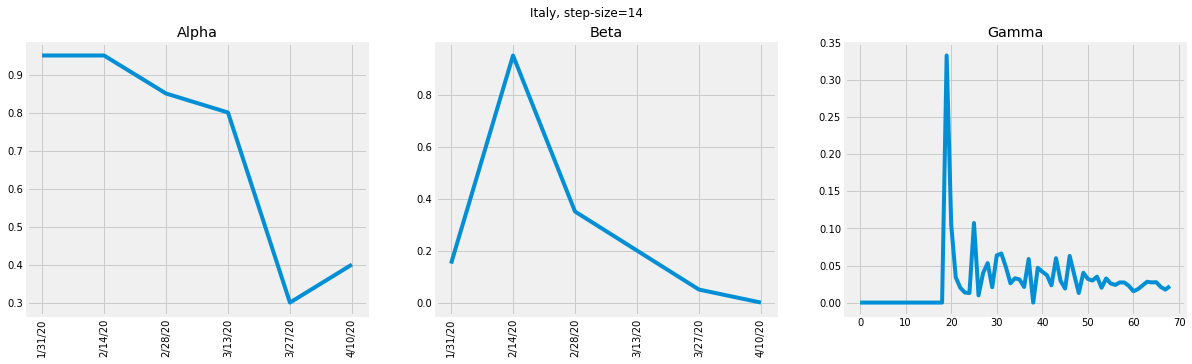

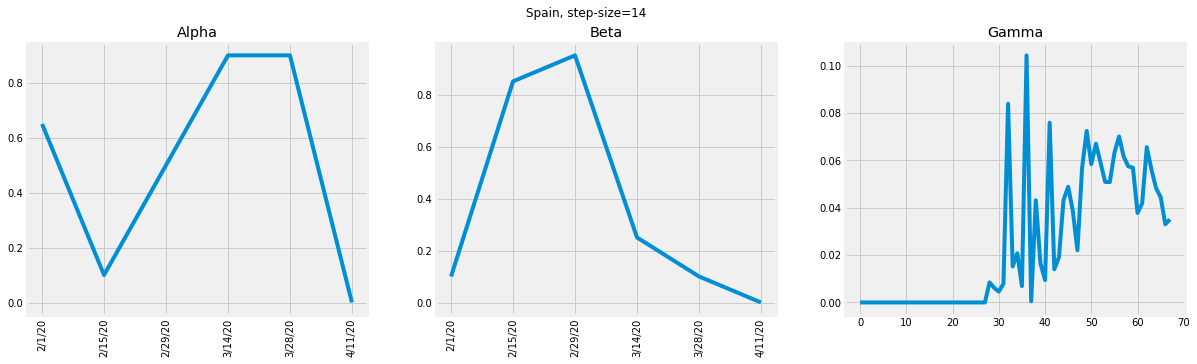

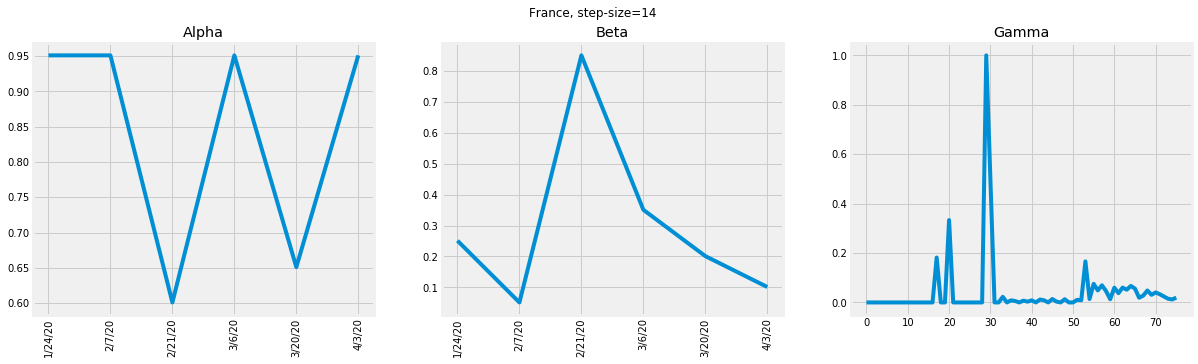

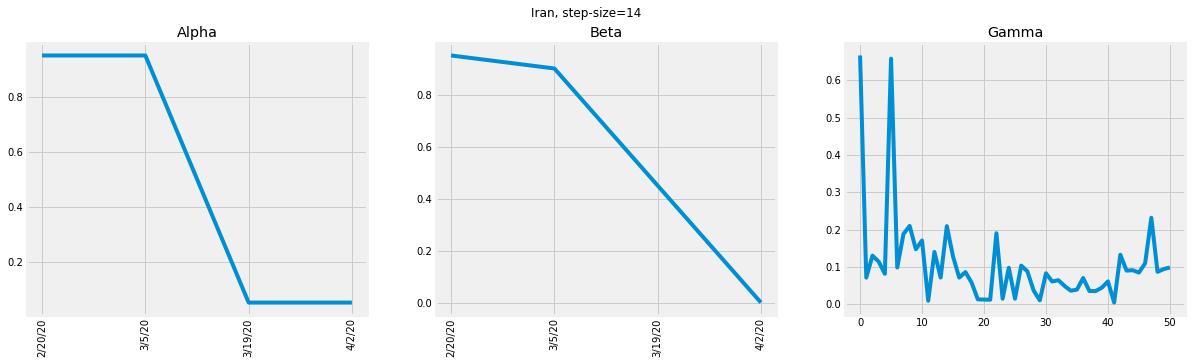

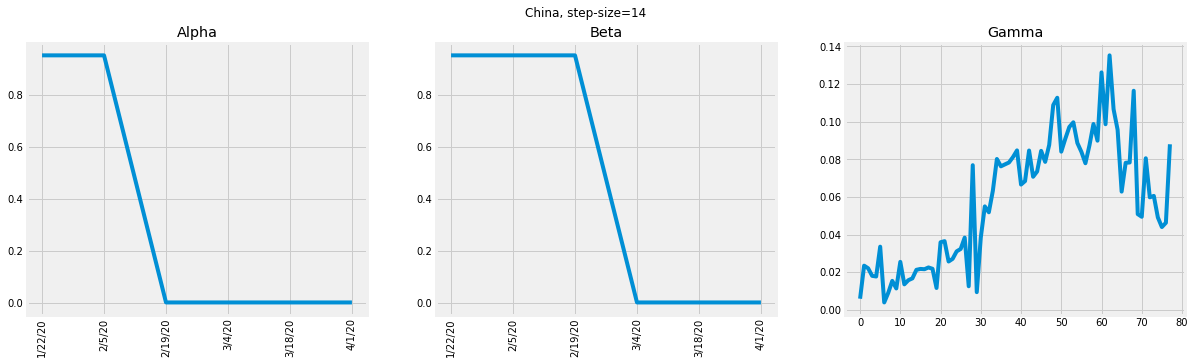

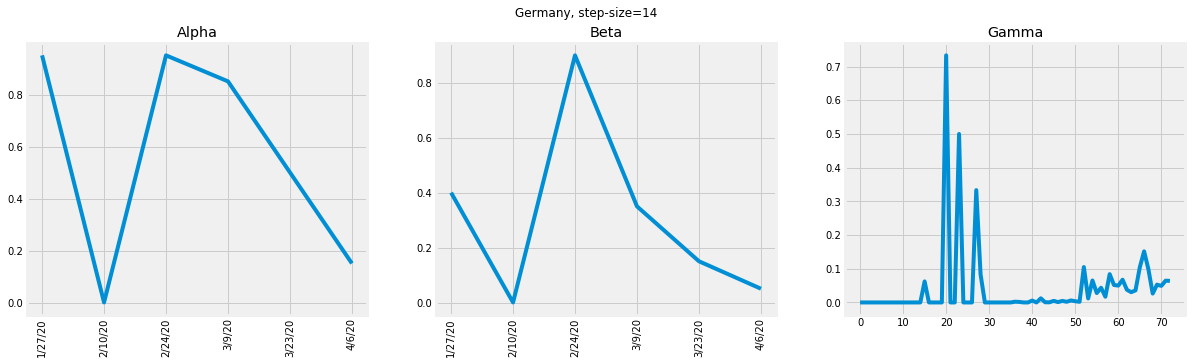

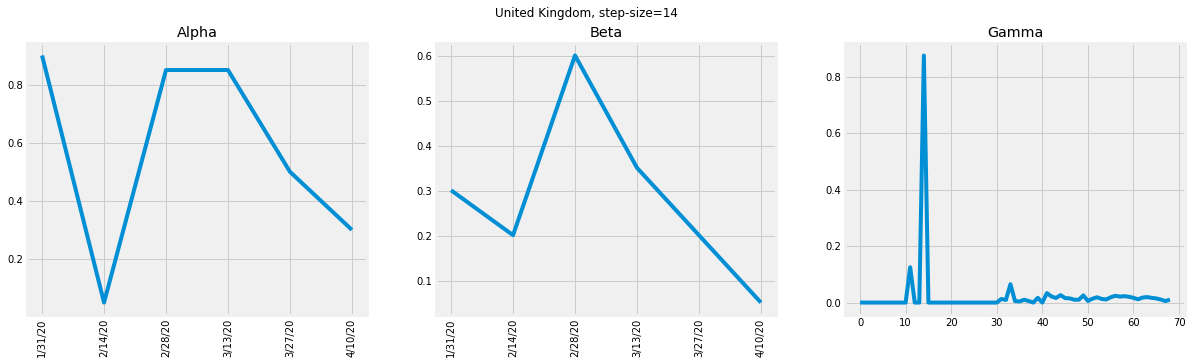

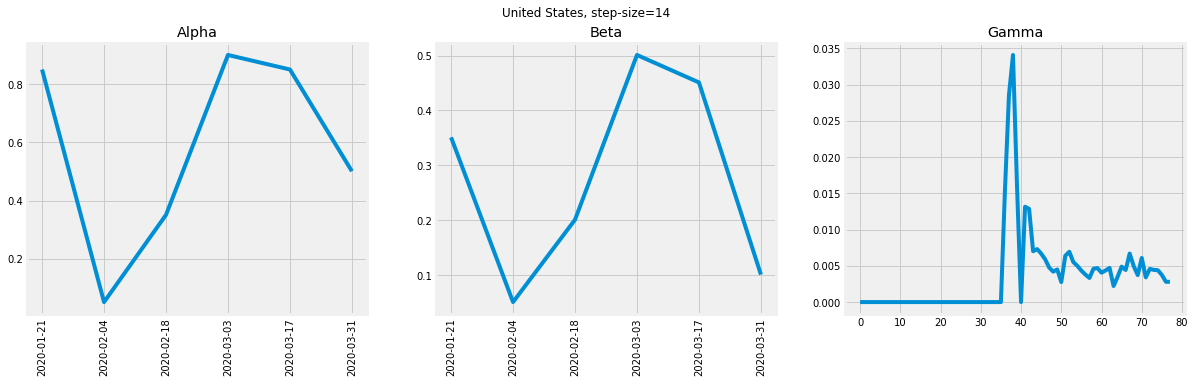

In [11]:
jobs = []
for stepSize in stepSizesToRunFor:
    computeParamsWithStepSize(stepSize, False)
#     p = multiprocessing.Process(target=computeParamsWithStepSize, args=(stepSize, ))
#     jobs.append(p)
#     p.start()

In [12]:
from sklearn import preprocessing
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,10))
cumulativeLossDf['Accuracy_Score'] = min_max_scaler.fit_transform(cumulativeLossDf['Accuracy_Score'].values.reshape(-1, 1))
cumulativeLossDf[cumulativeLossDf['Accuracy_Score'] == 0] = 0.0001
cumulativeLossDf['Accuracy_Score'] = 1/cumulativeLossDf['Accuracy_Score']

display(cumulativeLossDf)
cumulativeLossDf_group_by_stepSize = cumulativeLossDf.groupby('Step_Size').min()
cumulativeLossDf_group_by_stepSize = pd.DataFrame(cumulativeLossDf_group_by_stepSize)
display(cumulativeLossDf_group_by_stepSize)
display(cumulativeLossDf_group_by_stepSize.loc[cumulativeLossDf_group_by_stepSize['Accuracy_Score'].idxmax() ])

Country  Accuracy_Score  Step_Size
0   India           0.999863       -1.0      
1   Pakistan        0.998358       -1.0      
2   Italy           0.261221       -1.0      
3   Spain           0.350724       -1.0      
4   France          0.603898       -1.0      
5   Iran            0.681092       -1.0      
6   China           0.217432       -1.0      
7   Germany         0.474287       -1.0      
8   United Kingdom  0.845086       -1.0      
9   United States   0.100000       -1.0      
10  India           0.999977        7.0      
11  Pakistan        1.000000        7.0      
12  Italy           0.964656        7.0      
13  Spain           0.988242        7.0      
14  France          0.975698        7.0      
15  Iran            0.969481        7.0      
16  China           0.455602        7.0      
17  Germany         0.993207        7.0      
18  United Kingdom  0.986807        7.0      
19  United States   0.876746        7.0      
20  India           0.981548        21.0     
21  Pakistan        0.999978        21.0     
22  Italy           0.929917        21.0     
23  Spain           0.163536        21.0     
24  France          0.879021        21.0     
25  Iran            0.959904        21.0     
26  China           0.383691        21.0     
27  Germany         0.983530        21.0     
28  United Kingdom  0.994811        21.0     
29  United States   0.350234        21.0     
30  India           0.999988        14.0     
31  Pakistan        0.999995        14.0     
32  Italy           0.984669        14.0     
33  Spain           0.978677        14.0     
34  France          0.951758        14.0     
35  Iran            0.969728        14.0     
36  China           0.555973        14.0     
37  Germany         0.985591        14.0     
38  United Kingdom  0.990474        14.0     
39  United States   0.797934        14.0

Country  Accuracy_Score
Step_Size                        
-1.0       China   0.100000      
 7.0       China   0.455602      
 14.0      China   0.555973      
 21.0      China   0.163536

Country           China   
Accuracy_Score    0.555973
Name: 14.0, dtype: object